In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages
from projects.ephys.population import to_color
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
import cv2
import xarray as xr
mpl.rcParams.update({'font.size':10})

In [2]:
from sklearn.neighbors import KernelDensity

In [3]:
figpath = '/home/niell_lab/Desktop/figs_061522/'

# missing head-fixed PSTHs

In [ ]:
bad = []
for ind, x in hffm['norm_Rc_psth'][hffm['use']].iteritems():
    if any(np.isnan(x.astype(float))):
        bad.append(ind)
len(bad)

In [ ]:
plt.plot(hffm['Rc_psth'].iloc[42])

In [ ]:
bad_fr = []
for ind in bad:
    bad_fr.append(hffm.loc[ind,'Fm_fr'])

In [ ]:
np.argmax(bad_fr)

In [ ]:
bad[17]

In [ ]:
hffm.loc[42,'Fm_fr']

In [ ]:
len(hffm.loc[715,'Wn_spikeT'])

In [ ]:
len(hffm.loc[715,'Wn_spikeT']) / (hffm.loc[715,'Wn_eyeT'][-1] - hffm.loc[715,'Wn_eyeT'][0])

In [ ]:
bad = []
for ind, x in hffm['norm_Sn_psth'].iteritems():
    if any(np.isnan(x.astype(float))):
        bad.append(ind)
len(bad)

In [ ]:
hffm['session'].iloc[bad].unique()

In [ ]:
Rc_use = [i for i in hffm.index.values if i not in bad]

In [ ]:
hffm['gazecluster'].iloc[Sn_use].value_counts()

In [ ]:
def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

def keep_first_saccade(eventT, win=0.020):
    duplicates = set([])
    for t in eventT:
        new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

In [ ]:
sn_count = []
sn_min = []
rc_count = []
rc_min = []
for i, s in enumerate(hffm['session'].unique()):
    session = hffm[hffm['session']==s].iloc[0]
    sn = np.sum(np.array(session['Sn_dEye_dps'] > 240)) + np.sum(np.array(session['Sn_dEye_dps'] < -240))
    snMin = (session['Sn_eyeT'][-1]).astype(float) - (session['Sn_eyeT'][0]).astype(float)
    rc = np.sum(np.array(session['Rc_dEye_dps'] > 240)) + np.sum(np.array(session['Rc_dEye_dps'] < -240))
    rcMin = (session['Rc_eyeT'][-1]).astype(float) - (session['Rc_eyeT'][0]).astype(float)
    sn_count.append(sn); sn_min.append(snMin)
    rc_count.append(rc); rc_min.append(rcMin)

In [ ]:
time = np.array(rc_min)/60
newcounts = np.array(rc_count)/time
print('Sn mean={}, std={}'.format(np.mean(newcounts), np.std(newcounts)))

In [ ]:
movcount = {}
for i, s in enumerate(hffm['session'].unique()):
    print(s)
    session = hffm[hffm['session']==s].iloc[0]
    fm_sec = (session['FmLt_eyeT'][-1]).astype(float) - (session['FmLt_eyeT'][0]).astype(float)
    wn_sec = (session['Wn_eyeT'][-1]).astype(float) - (session['Wn_eyeT'][0]).astype(float)
    gazeL = len(session['FmLt_gazeshift_left_saccTimes_dHead1'])
    gazeR = len(session['FmLt_gazeshift_right_saccTimes_dHead1'])
    compL = len(session['FmLt_comp_left_saccTimes_dHead1'])
    compR = len(session['FmLt_comp_right_saccTimes_dHead1'])
    wnL = np.sum(np.array(session['Wn_dEye_dps'] > 240))
    wnR = np.sum(np.array(session['Wn_dEye_dps'] < -240))
    out = {
        'gazeL': gazeL,
        'gazeR': gazeR,
        'compL': compL,
        'compR': compR,
        'hfL': wnL,
        'hfR': wnR,
        'len_fm': fm_sec,
        'len_hf': wn_sec
    }
    movcount[i] = out

In [ ]:
len(hffm[hffm['fr']>2])

In [ ]:
compL

In [ ]:
compL[3] + compR[3]

In [ ]:
gazeL = []; gazeR = []
compL = []; compR = []
hfL = []; hfR = []
hf_sec = []; fm_sec = []

for i in range(10):
    vals = movcount[i]
    gazeL.append(vals['gazeL'])
    gazeR.append(vals['gazeR'])
    compL.append(vals['compL'])
    compR.append(vals['compR'])
    hfL.append(vals['hfL'])
    hfR.append(vals['hfR'])
    fm_sec.append(vals['len_fm'])
    hf_sec.append(vals['len_hf'])

In [ ]:
vals = [gazeL, gazeR, compL, compR, hfL, hfR, fm_sec, hf_sec]
names = ['left gaze','right gaze','left comp','right comp',
        'left hf', 'right hf', 'fm time', 'hf time']
for i in range(8):
    name = names[i]; val = vals[i]
    if i==6 or i==7:
        val1 = [x/60 for x in val]
    else:
        val1 = val
    print('{} mean={} std={}'.format(name, np.mean(val1), np.std(val1)))

In [ ]:
np.std(np.array(hfL) + np.array(hfR))

In [ ]:
np.mean(compL+compR)

In [ ]:
np.std(compL+compR)

In [ ]:
gazerate = []
comprate = []
hfrate = []

for i in range(10):
    hfmin = (hf_sec[i]/60)
    fmmin = (fm_sec[i]/60)
    
    gazerate.append((gazeL[i]+gazeR[i])/fmmin)
    comprate.append((compL[i]+compR[i])/fmmin)
    hfrate.append((hfL[i]+hfR[i])/hfmin)


print('gaze/min: mean={}, std={}'.format(np.mean(gazerate), np.std(gazerate)))
print('comp/min: mean={}, std={}'.format(np.mean(comprate), np.std(comprate)))
print('hf/min: mean={}, std={}'.format(np.mean(hfrate), np.std(hfrate)))

In [ ]:
for 

In [ ]:
comprate

In [ ]:
hffm['gazecluster'].value_counts()

In [ ]:
ltdk['dark_responsive'].value_counts()

In [ ]:
len(ltdk)

In [ ]:
ltdk['gazecluster'].value_counts()

In [ ]:
9/401

In [ ]:
len(hffm)

In [ ]:
np.sum(hffm['gazecluster']=='unresponsive')

In [ ]:
(850-165)

# Load data

In [4]:
hffm = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061522/hffm_061522.pickle')

In [5]:
ltdk = pd.read_pickle('/home/niell_lab/Data/freely_moving_ephys/batch_files/061522/ltdk_061522.pickle')

# Colormaps and reused values

In [6]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}
psth_bins = np.arange(-1,1.001,1/1000)

# Some basic calculations

## Functions to make figures later on

In [7]:
def drop_nan_along(x, axis=1):
    # axis=1 will drop along columns (i.e. any rows with NaNs will be dropped)
    x = x[~np.isnan(x).any(axis=axis)]
    return x

In [8]:
def jitter_ax(center, size):
    return np.ones(size)+np.random.uniform(center-0.2, center+0.2, size)

In [9]:
def plot_cprop_scatter(panel, data, prop_name, use_median=False):
    for c, cluster in enumerate(['early','late','biphasic','negative']):
        cluster_data = data[prop_name][data['gazecluster']==cluster]
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
        panel.plot(x_jitter, cluster_data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.nanmedian(cluster_data)
        elif not use_median:
            hline = np.nanmean(cluster_data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
        panel.vlines(c, hline-err, hline+err, color='k', linewidth=2)
        panel.set_xticks(range(4), ['early','late','biphasic','negative'])

In [10]:
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    panel.set_xlabel('time (msec)')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img

## More demo data stuff

In [43]:
demo = hffm[hffm['session']=='102621_J558NC_control_Rig2'].iloc[0]

dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

left = demo['FmLt_gazeshift_left_saccTimes_dHead']
right = demo['FmLt_gazeshift_right_saccTimes_dHead']
comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead'], demo['FmLt_comp_right_saccTimes_dHead']])

plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/25)), replace=False))
gazemovs = np.hstack([left, right])

## Movement counts

### for hffm

In [318]:
Lgaze_count = []; Rgaze_count = []
Lcomp_count = []; Rcomp_count = []
mins = []
for session in hffm['session'].unique():
    mins.append(((hffm['FmLt_eyeT'][hffm['session']==session].iloc[0]).size)/60/60)
    Lgaze_count.append(len(hffm['FmLt_gazeshift_left_saccTimes_dHead1'][hffm['session']==session].iloc[0]))
    Rgaze_count.append(len(hffm['FmLt_gazeshift_right_saccTimes_dHead1'][hffm['session']==session].iloc[0]))
    Lcomp_count.append(len(hffm['FmLt_comp_left_saccTimes_dHead1'][hffm['session']==session].iloc[0]))
    Rcomp_count.append(len(hffm['FmLt_comp_right_saccTimes_dHead1'][hffm['session']==session].iloc[0]))

In [321]:
len(hffm['session'].unique())

9

In [320]:
np.std(mins)

8.201838896172521

In [323]:
np.mean(np.array(Lcomp_count) + np.array(Rcomp_count))

12656.666666666666

In [ ]:
Lgaze_countL = []; Rgaze_countL = []
Lcomp_countL = []; Rcomp_countL = []
for session in ltdk.data['session'].unique():
    minutes = ((ltdk.data['FmLt_eyeT'][ltdk.data['session']==session].iloc[0]).size)/60/60
    Lgaze_countL.append(len(ltdk.data['FmLt_gazeshift_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rgaze_countL.append(len(ltdk.data['FmLt_gazeshift_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Lcomp_countL.append(len(ltdk.data['FmLt_comp_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rcomp_countL.append(len(ltdk.data['FmLt_comp_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
Lgaze_countD = []; Rgaze_countD = []
Lcomp_countD = []; Rcomp_countD = []
for session in ltdk.data['session'].unique():
    minutes = ((ltdk.data['FmDk_eyeT'][ltdk.data['session']==session].iloc[0]).size)/60/60
    Lgaze_countD.append(len(ltdk.data['FmDk_gazeshift_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rgaze_countD.append(len(ltdk.data['FmDk_gazeshift_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Lcomp_countD.append(len(ltdk.data['FmDk_comp_left_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)
    Rcomp_countD.append(len(ltdk.data['FmDk_comp_right_saccTimes_dHead'][ltdk.data['session']==session].iloc[0])/minutes)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_count)), Lgaze_count, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_count)), Rgaze_count, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_count)), Lcomp_count, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_count)), Rcomp_count, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_count, Rgaze_count, Lcomp_count, Rcomp_count]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/hffm_saccade_rate.pdf')

### for ltdk

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_countL)), Lgaze_countL, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_countL)), Rgaze_countL, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_countL)), Lcomp_countL, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_countL)), Rcomp_countL, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_countL, Rgaze_countL, Lcomp_countL, Rcomp_countL]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/ltdk_Lt_saccade_rate.pdf')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(Lgaze_countD)), Lgaze_countD, '.', color=colors['gaze'])
ax.plot(jitter_ax(1, len(Rgaze_countD)), Rgaze_countD, '.', color=colors['gaze'])
ax.plot(jitter_ax(2, len(Lcomp_countD)), Lcomp_countD, '.', color=colors['comp'])
ax.plot(jitter_ax(3, len(Rcomp_countD)), Rcomp_countD, '.', color=colors['comp'])


for i, vals in enumerate([Lgaze_countD, Rgaze_countD, Lcomp_countD, Rcomp_countD]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,5,1), labels=['L','R','L','R'])
ax.set_xlim([0.5,4.5])
# ax.set_yticks(np.linspacLe(0,24000,6))
ax.set_ylim([0, 450])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/ltdk_Dk_saccade_rate.pdf')

## Rc and Sn responsive

In [11]:
def psth_modind(psth, baseval='range'):
    # modulation in terms of spike rate
    psth = psth.astype(float)
    if baseval=='range':
        use = psth - np.mean(psth[0:800].copy())
    elif baseval=='zero':
        use = psth - psth[1000]
    mod = np.max(np.abs(use[1000:1250]))
    return mod

In [12]:
for ind, row in hffm.iterrows():
    sec = row['Rc_eyeT'][-1].astype(float) - row['Rc_eyeT'][0].astype(float)
    sp = len(row['Rc_spikeT'])
    hffm.at[ind, 'Rc_fr'] = sp/sec

    hffm.at[ind, 'raw_mod_for_Rc'] = psth_modind(row['Rc_psth'])

    hffm.at[ind, 'norm_mod_for_Rc'] = psth_modind(row['norm_Rc_psth'])
    
hffm['Rc_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Rc']>1) and (row['norm_mod_for_Rc']>0.1):
        hffm.at[ind, 'Rc_responsive'] = True
print(hffm['Rc_responsive'].sum())

472


In [13]:
for ind, row in hffm.iterrows():
    sec = row['Sn_eyeT'][-1].astype(float) - row['Sn_eyeT'][0].astype(float)
    sp = len(row['Sn_spikeT'])
    hffm.at[ind, 'Sn_fr'] = sp/sec
    
    hffm.at[ind, 'raw_mod_for_Sn'] = psth_modind(row['Sn_on_background_psth'], baseval='zero')

    hffm.at[ind, 'norm_mod_for_Sn'] = psth_modind(row['norm_Sn_psth'], baseval='zero')
    
hffm['Sn_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Sn']>1) and (row['norm_mod_for_Sn']>0.1):
        hffm.at[ind, 'Sn_responsive'] = True
print(hffm['Sn_responsive'].sum())

333


## temp seq

In [39]:
def calc_latency(psth):
    # use norm PSTH
    ind = np.argmax(psth[1025:1250])+1025 # was 1000:1170
    peakT = psth_bins[ind]
    val = psth[ind]
    return peakT, val

In [40]:
for ind in hffm.index.values:
    Rc_peakT, Rc_peakVal = calc_latency(hffm.loc[ind,'norm_Rc_psth'])
    Sn_peakT, Sn_peakVal = calc_latency(hffm.loc[ind,'norm_Sn_psth'])
    Gaze_peakT, Gaze_peakVal = calc_latency(hffm.loc[ind,'pref_gazeshift_psth'])
    
    hffm.at[ind, 'rc_peakT'] = Rc_peakT
    hffm.at[ind, 'sn_peakT'] = Sn_peakT
    hffm.at[ind, 'FmLt_gazeshift_peakT'] = Gaze_peakT

use_cols = ['FmLt_gazeshift_peakT','gazecluster','pref_gazeshift_psth','nonpref_gazeshift_psth','Rc_responsive','Sn_responsive',
            'pref_comp_psth','Gt_responsive','nonpref_comp_psth','norm_Rc_psth','norm_Sn_psth','tf_pref_cps','sf_pref_cpd','gazeshift_responsive']
    
sorted_df = hffm[use_cols].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[sorted_df['gazecluster']=='unresponsive'][sorted_df['gazeshift_responsive']==False].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth'])
tseq_unresp_rc = flatten_series(tseq_unresp['norm_Rc_psth'][sorted_df['Rc_responsive']])
tseq_unresp_sn = flatten_series(tseq_unresp['norm_Sn_psth'][sorted_df['Sn_responsive']])

sorted_df.sort_values(by='FmLt_gazeshift_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['gazecluster']!='unresponsive'][sorted_df['gazeshift_responsive']==True].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['Rc_responsive']].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['Sn_responsive']].copy())
tseq_grat_tf = sorted_df['tf_pref_cps'][sorted_df['Gt_responsive']].copy().to_numpy()
tseq_grat_sf = sorted_df['sf_pref_cpd'][sorted_df['Gt_responsive']].copy().to_numpy()

tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

In [41]:
tseq_legend_col = sorted_df['gazecluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
u = np.zeros([np.size(tseq_unresp_pref,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

## part of fig. 2: hffm temp seq legend

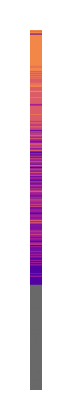

In [42]:
fig, ax = plt.subplots(1,1,figsize=(0.5,1.5), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(figpath, '2_hffm_tseq_legend.pdf'))

# Figure 1

## gaze-shifting vs. comp

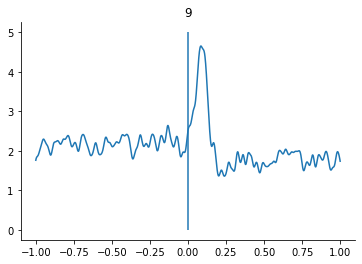

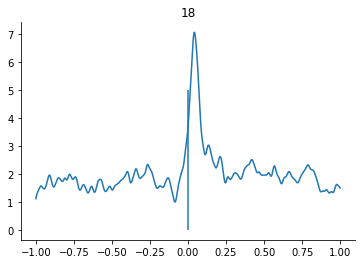

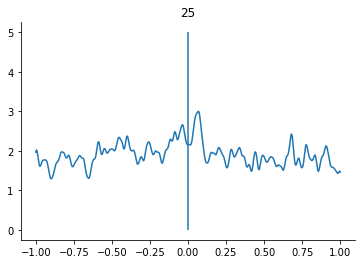

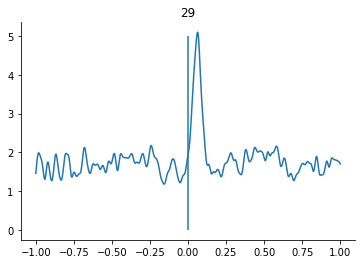

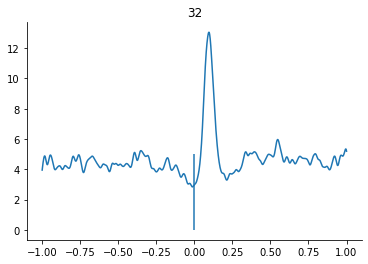

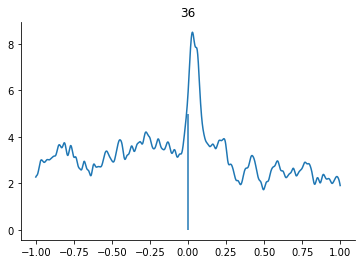

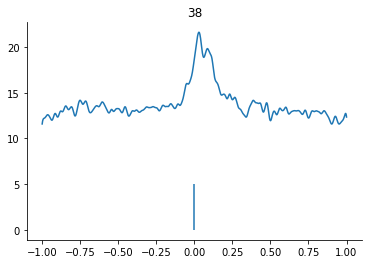

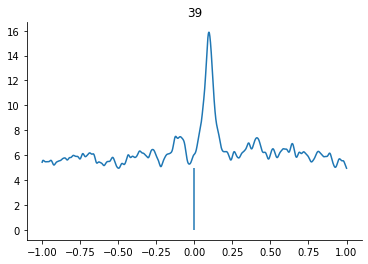

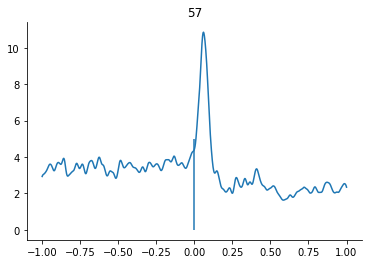

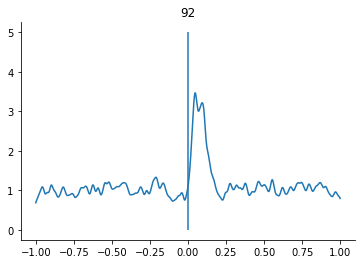

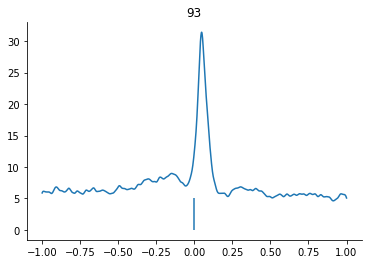

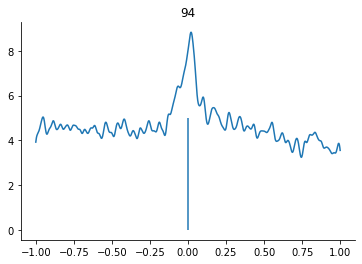

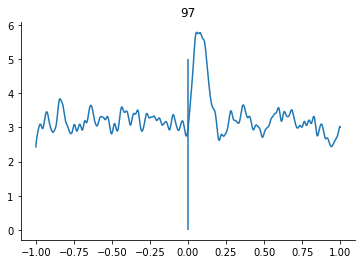

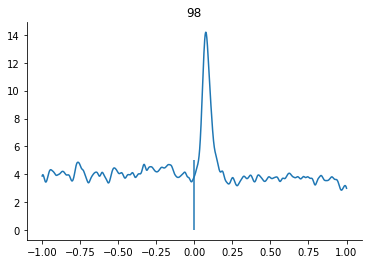

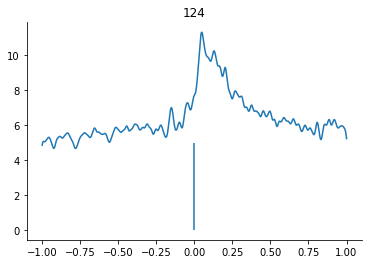

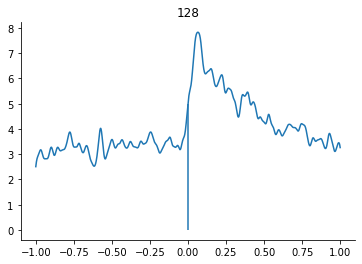

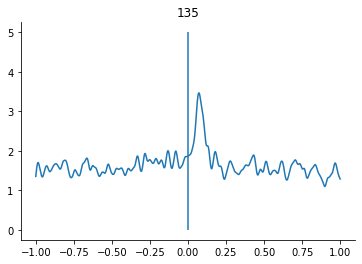

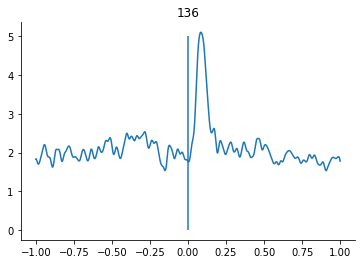

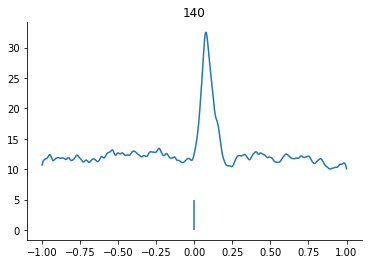

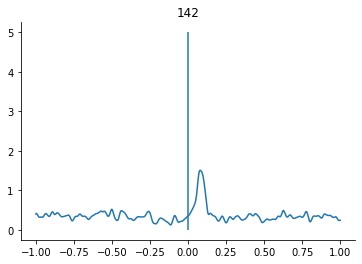

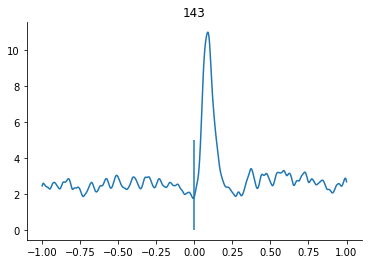

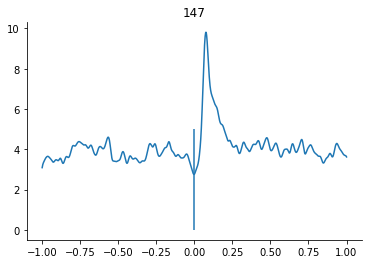

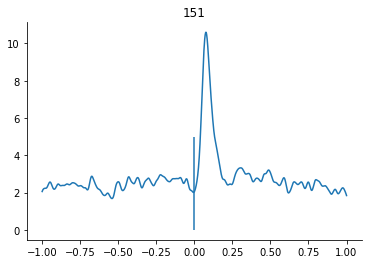

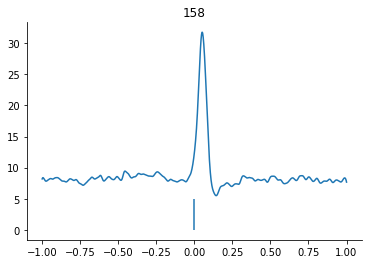

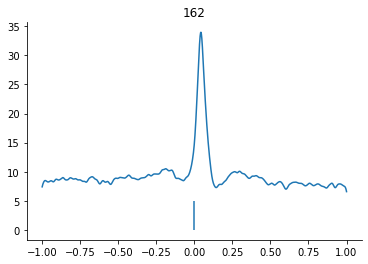

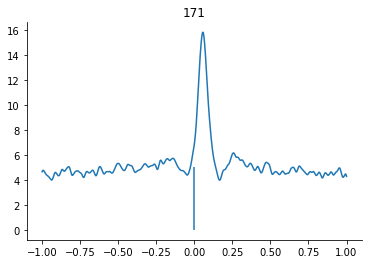

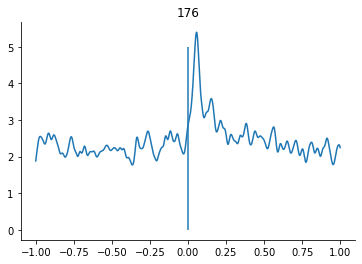

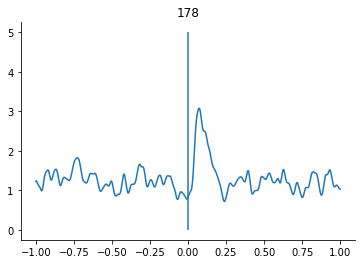

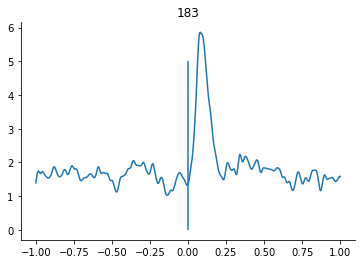

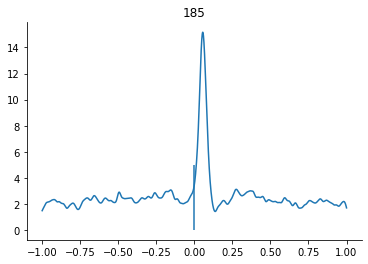

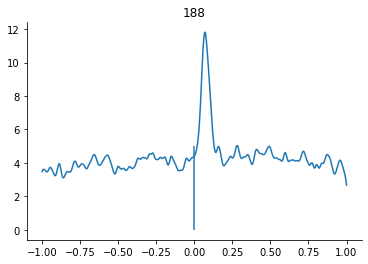

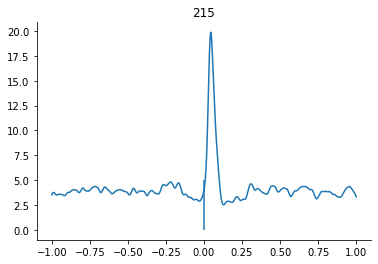

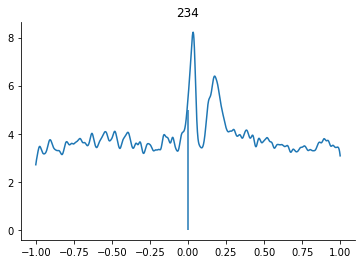

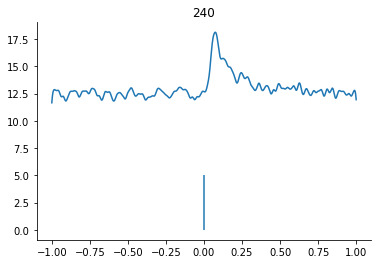

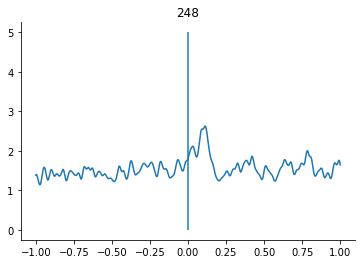

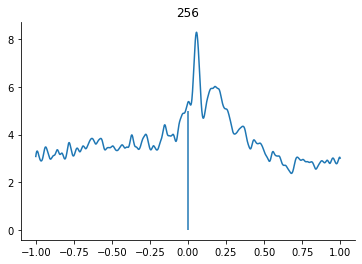

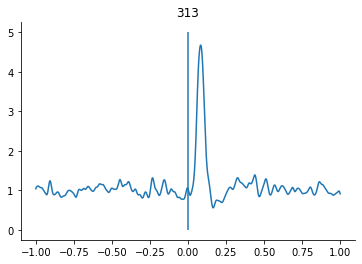

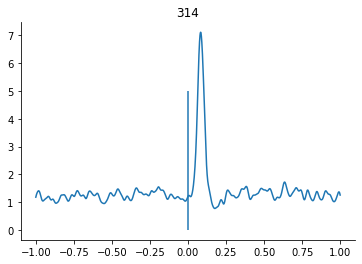

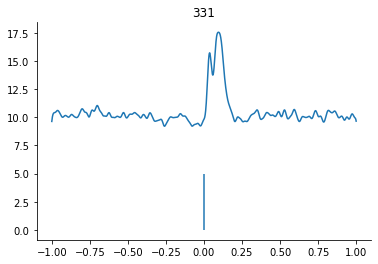

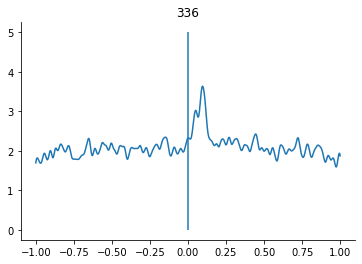

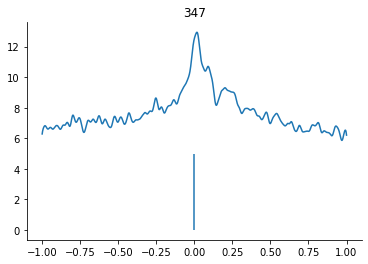

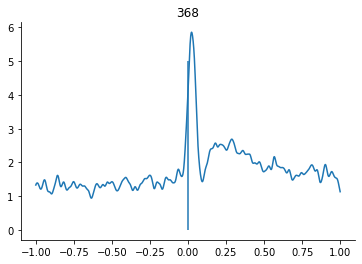

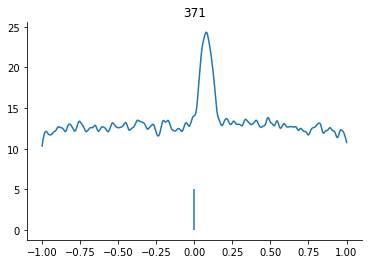

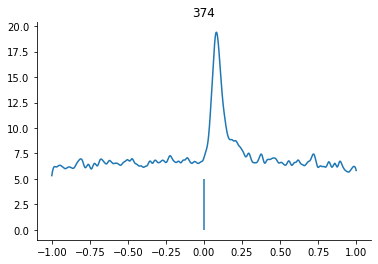

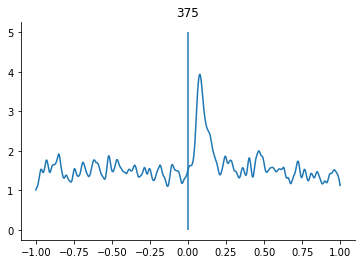

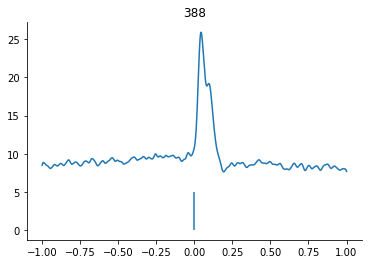

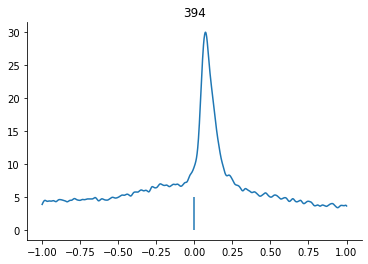

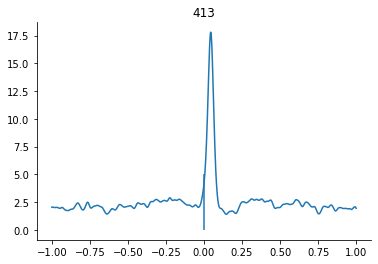

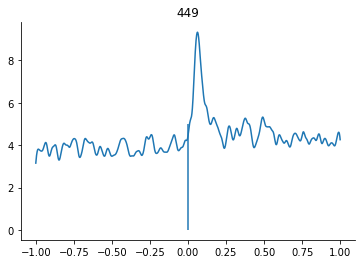

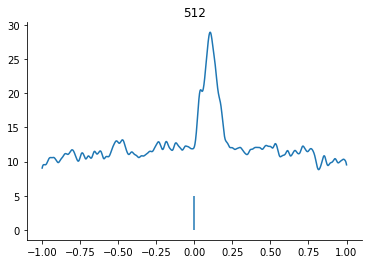

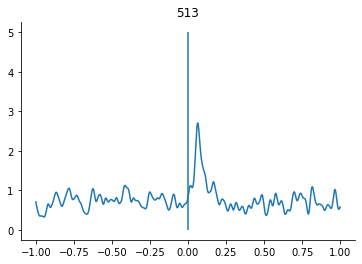

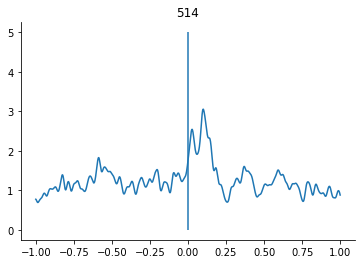

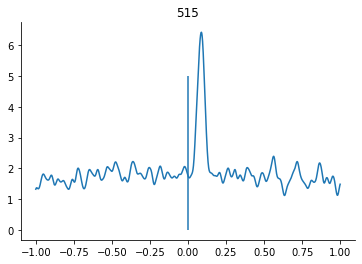

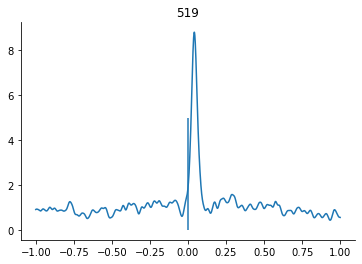

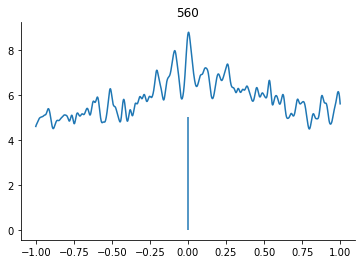

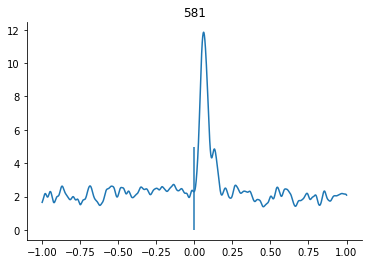

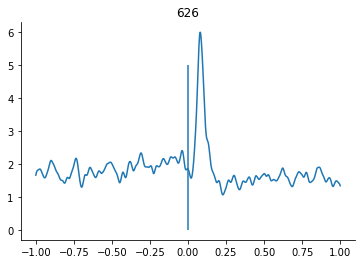

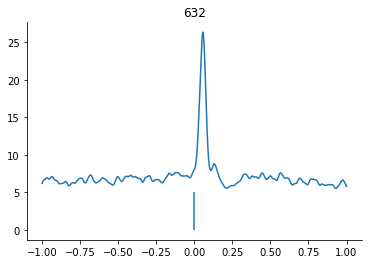

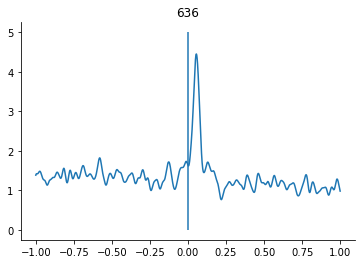

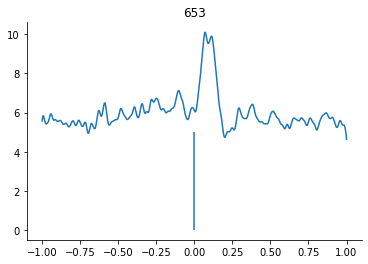

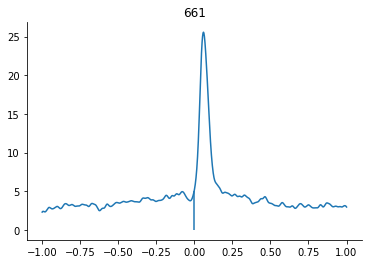

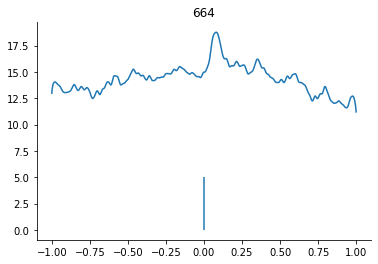

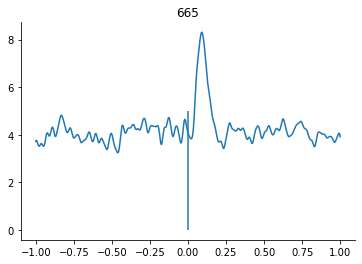

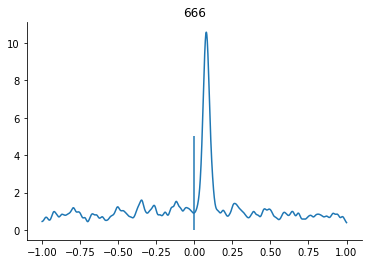

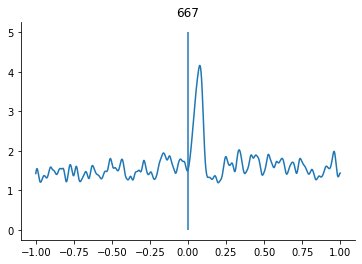

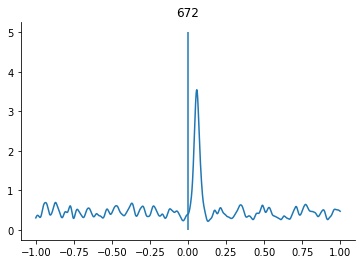

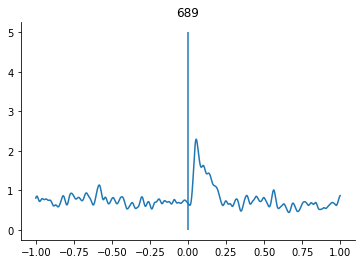

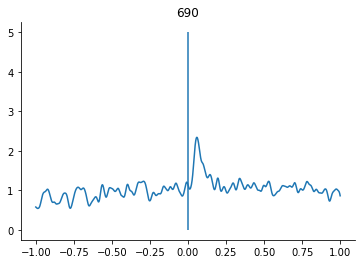

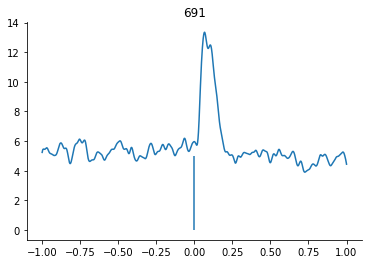

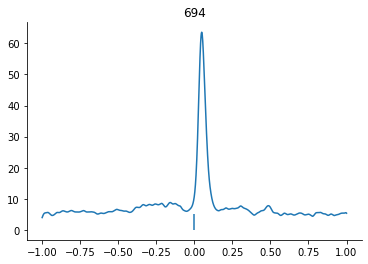

In [48]:
vals = hffm['pref_gazeshift_psth_raw'][hffm['gazecluster']=='early'][hffm['Fm_fr']<15].copy()
for i, x in enumerate(vals):
    plt.figure()
    plt.title(vals.index.values[i])
    plt.plot(psth_bins, x)
    plt.vlines(0, 0, 5)

In [324]:
len(hffm.index.values)

716

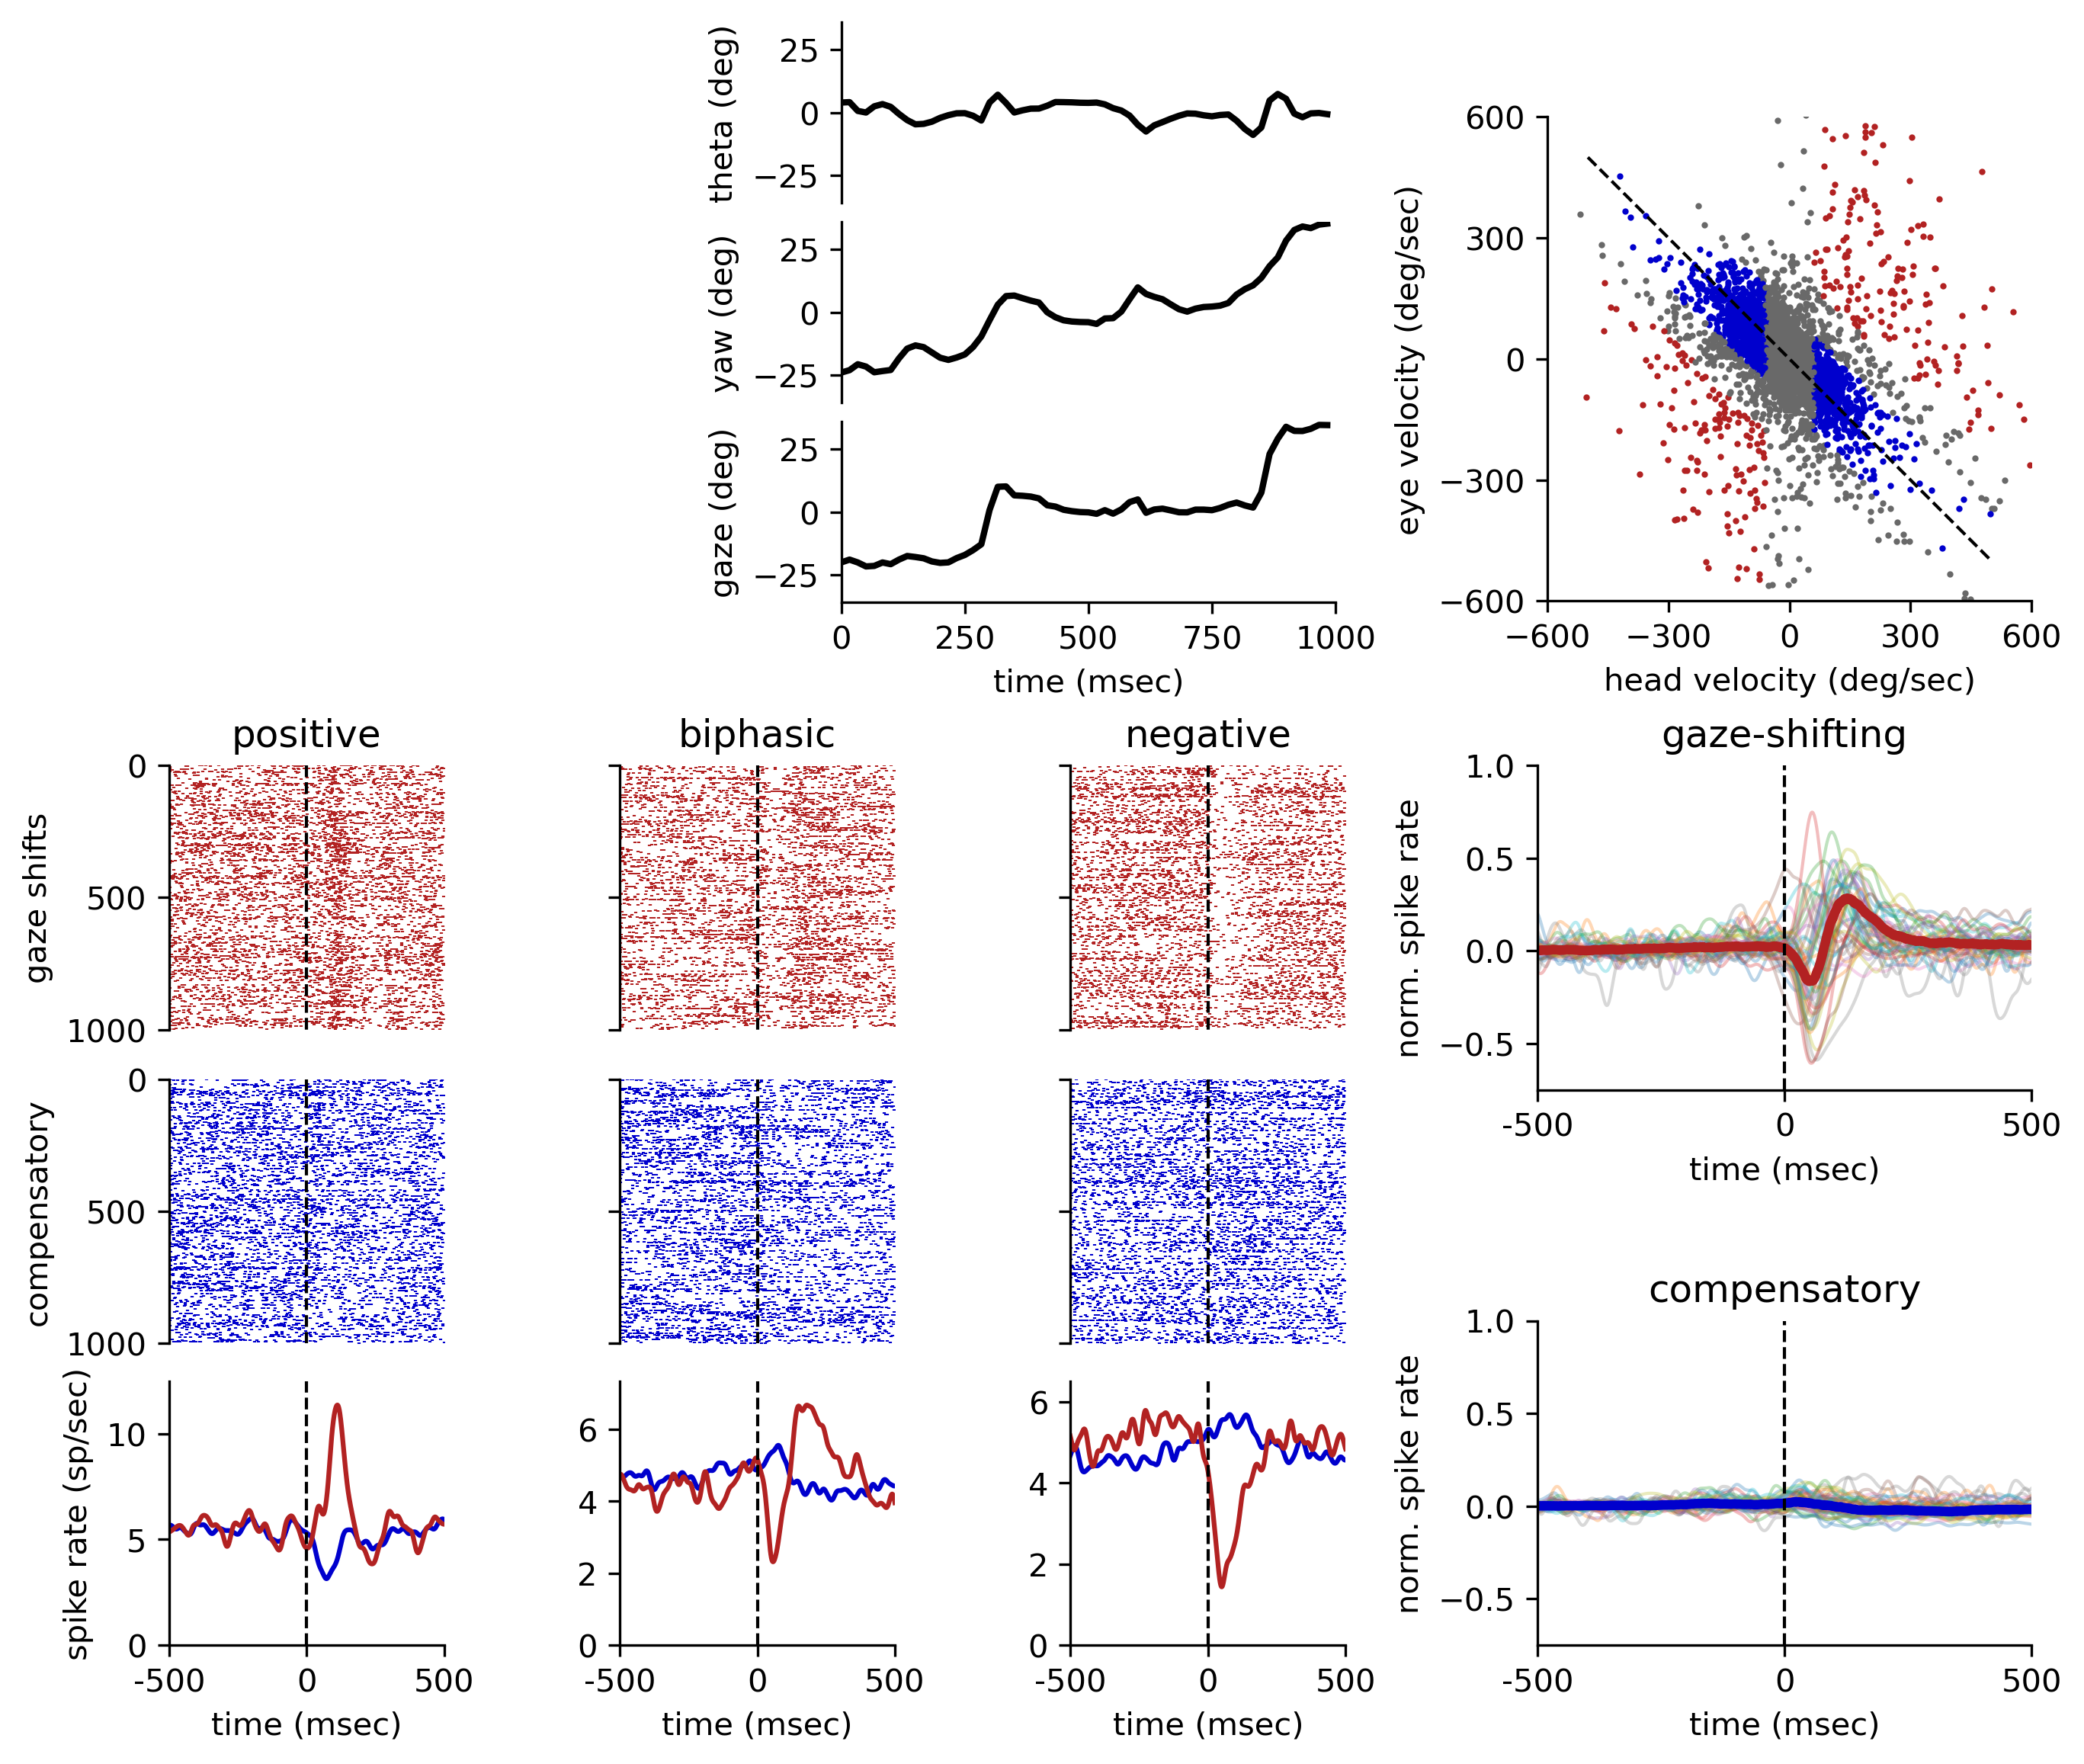

In [60]:
fig1 = plt.figure(constrained_layout=True, figsize=(9,7.6), dpi=300)
fig1spec = gridspec.GridSpec(nrows=5, ncols=3, figure=fig1, wspace=1.5, hspace=1.5)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=fig1spec[0:2,1], wspace=0, hspace=0.01)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[0:2,2], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[2:,0:2], wspace=0.15, hspace=-.05)

ax_pos_rasterG = fig1.add_subplot(fig1E2Fspec[0,0])
ax_biph_rasterG = fig1.add_subplot(fig1E2Fspec[0,1])
ax_neg_rasterG = fig1.add_subplot(fig1E2Fspec[0,2])

ax_pos_rasterC = fig1.add_subplot(fig1E2Fspec[1,0])
ax_biph_rasterC = fig1.add_subplot(fig1E2Fspec[1,1])
ax_neg_rasterC = fig1.add_subplot(fig1E2Fspec[1,2])

ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(2,1,subplot_spec=fig1spec[2:,2:], wspace=0.2, hspace=0.1)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[1,0])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [39,112,126] # [171,112,126]
ex_units_direcprefs = ['left','left','right']

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=2, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-ylim_val,ylim_val])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=2)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-ylim_val,ylim_val])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=2)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1000,5).astype(int))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-ylim_val,ylim_val])
ax_gaze.set_xlabel('time (msec)')

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if eyeT[i] in gazemovs:
        c = colors['gaze']
    elif eyeT[i] in comp:
        c = colors['comp']
    elif (np.abs(dHead_data[i])<60) or ((dGaze_i<240) and (dGaze_i>120)):
        c = 'dimgray'
    else:
        continue
    ax_dEyeHead.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=2)

ax_dEyeHead.set_aspect('equal','box')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

num_movements = 1000
raster_panelsG = [ax_pos_rasterG, ax_biph_rasterG, ax_neg_rasterG]
raster_panelsC = [ax_pos_rasterC, ax_biph_rasterC, ax_neg_rasterC]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.iloc[u]
    rasterG = raster_panelsG[i]
    rasterC = raster_panelsC[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]
    
    rasterG.set_title(['positive','biphasic','negative'][i])

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead1'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead1'], row['FmLt_comp_right_saccTimes_dHead1']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterG.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=0.3)

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterC.plot(sp, np.ones(sp.size)*n, '|', color=colors['comp'], markersize=0.3) # was 0.25
    
    rasterG.set_ylim([num_movements, 0]); rasterC.set_ylim([num_movements,0])
    rasterG.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    rasterC.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    if i == 0:
        rasterG.set_ylabel('gaze shifts'); rasterC.set_ylabel('compensatory')
        rasterG.set_yticks(np.linspace(0, num_movements, 3))
        rasterC.set_yticks(np.linspace(0, num_movements, 3))
    else:
        rasterG.set_yticks(np.linspace(0, num_movements, 3),labels=[])
        rasterC.set_yticks(np.linspace(0, num_movements, 3),labels=[])
    rasterG.set_xticks([]); rasterC.set_xticks([])
    rasterG.set_xlim([-.5,.5]); rasterC.set_xlim([-.5,.5])
    rasterG.axes.spines.bottom.set_visible(False); rasterC.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead1'.format(LR)], color=colors['comp'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead1'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead1'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('spike rate (sp/sec)')
    sdf_panel.set_xlabel('time (msec)')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')

possible_inds = hffm['pref_comp_psth'][hffm['fr']>2].index.values
np.random.seed(2)
example_inds = np.sort(np.random.choice(possible_inds, size=50, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.loc[ind,'pref_gazeshift_psth'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.loc[ind,'pref_comp_psth'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-0.75,1])
ax_ex_comp.set_ylim([-0.75,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('time (msec)')
ax_ex_gaze.set_xlabel('time (msec)')

all_comp = flatten_series(hffm['pref_comp_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])
all_gaze = flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']])

comp_mean = np.nanmedian(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmedian(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))
ax_ex_comp.set_title('compensatory')
ax_ex_gaze.set_title('gaze-shifting')
ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

ax_ex_gaze.vlines(0, -0.75, 1, 'k', linewidth=1, linestyle='dashed')
ax_ex_comp.vlines(0, -0.75, 1, 'k', linewidth=1, linestyle='dashed')

fig1.savefig(os.path.join(figpath, '1_gazeshift_v_comp.pdf'))

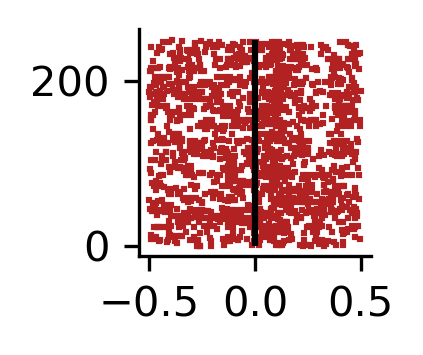

In [355]:
plt.figure(figsize=(1,1), dpi=300)
row = hffm.loc[39]

count = 250

gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead1'.format(LR)].copy()
plot_gs = np.random.choice(gazeshifts, size=count, replace=False)

for n, s in enumerate(plot_gs):
    sp = row['FmLt_spikeT']-s
    sp = sp[np.abs(sp)<=0.5]
    plt.plot(sp, np.ones(sp.size)*n, 's', color=colors['gaze'], markersize=0.5)

plt.vlines(0, 0, count, 'k')

In [329]:
len(ltdk.index.values)

265

In [331]:
len(ltdk['session'].unique())

7

In [341]:
ltdk['gazecluster'].value_counts()/265

unresponsive    0.283019
negative        0.211321
biphasic        0.203774
late            0.200000
early           0.101887
Name: gazecluster, dtype: float64

# Depth

## fix depth

In [ ]:
# {session name : position of layer 5 (i.e. sites from top of shank)}
# new_depths = {
#     '032022_J599LT_control_Rig2': 22
# }
# for newsession, newdepth in new_depths.items():
#     if len(hffm[hffm['ch']>=64][hffm['session']==newsession].index.values)>0:
#         num_sh = 4
#     else:
#         num_sh = 2
#     for ind, row in hffm[hffm['session']==newsession].iterrows():
#         hffm.at[ind, 'Wn_layer5cent_from_lfp'] = list(np.ones([num_sh]).astype(int)*int(newdepth))
#     for ind, row in hffm[hffm['session']==newsession].iterrows():
#         ch_spacing = 25/2; num_sites = 32
#         ch = row['ch']; ch_shank = int(np.floor(ch/32))
#         layer5cent = row['Wn_layer5cent_from_lfp'][ch_shank]
#         ch_depth = ch_spacing*(ch%32)-(layer5cent*ch_spacing)
#         # print('ind={}, ch={}, sh={}, cent={}, depth={}'.format(ind, ch, ch_shank, layer5cent, ch_depth))
#         hffm.at[ind, 'Wn_depth_from_layer5'] = ch_depth

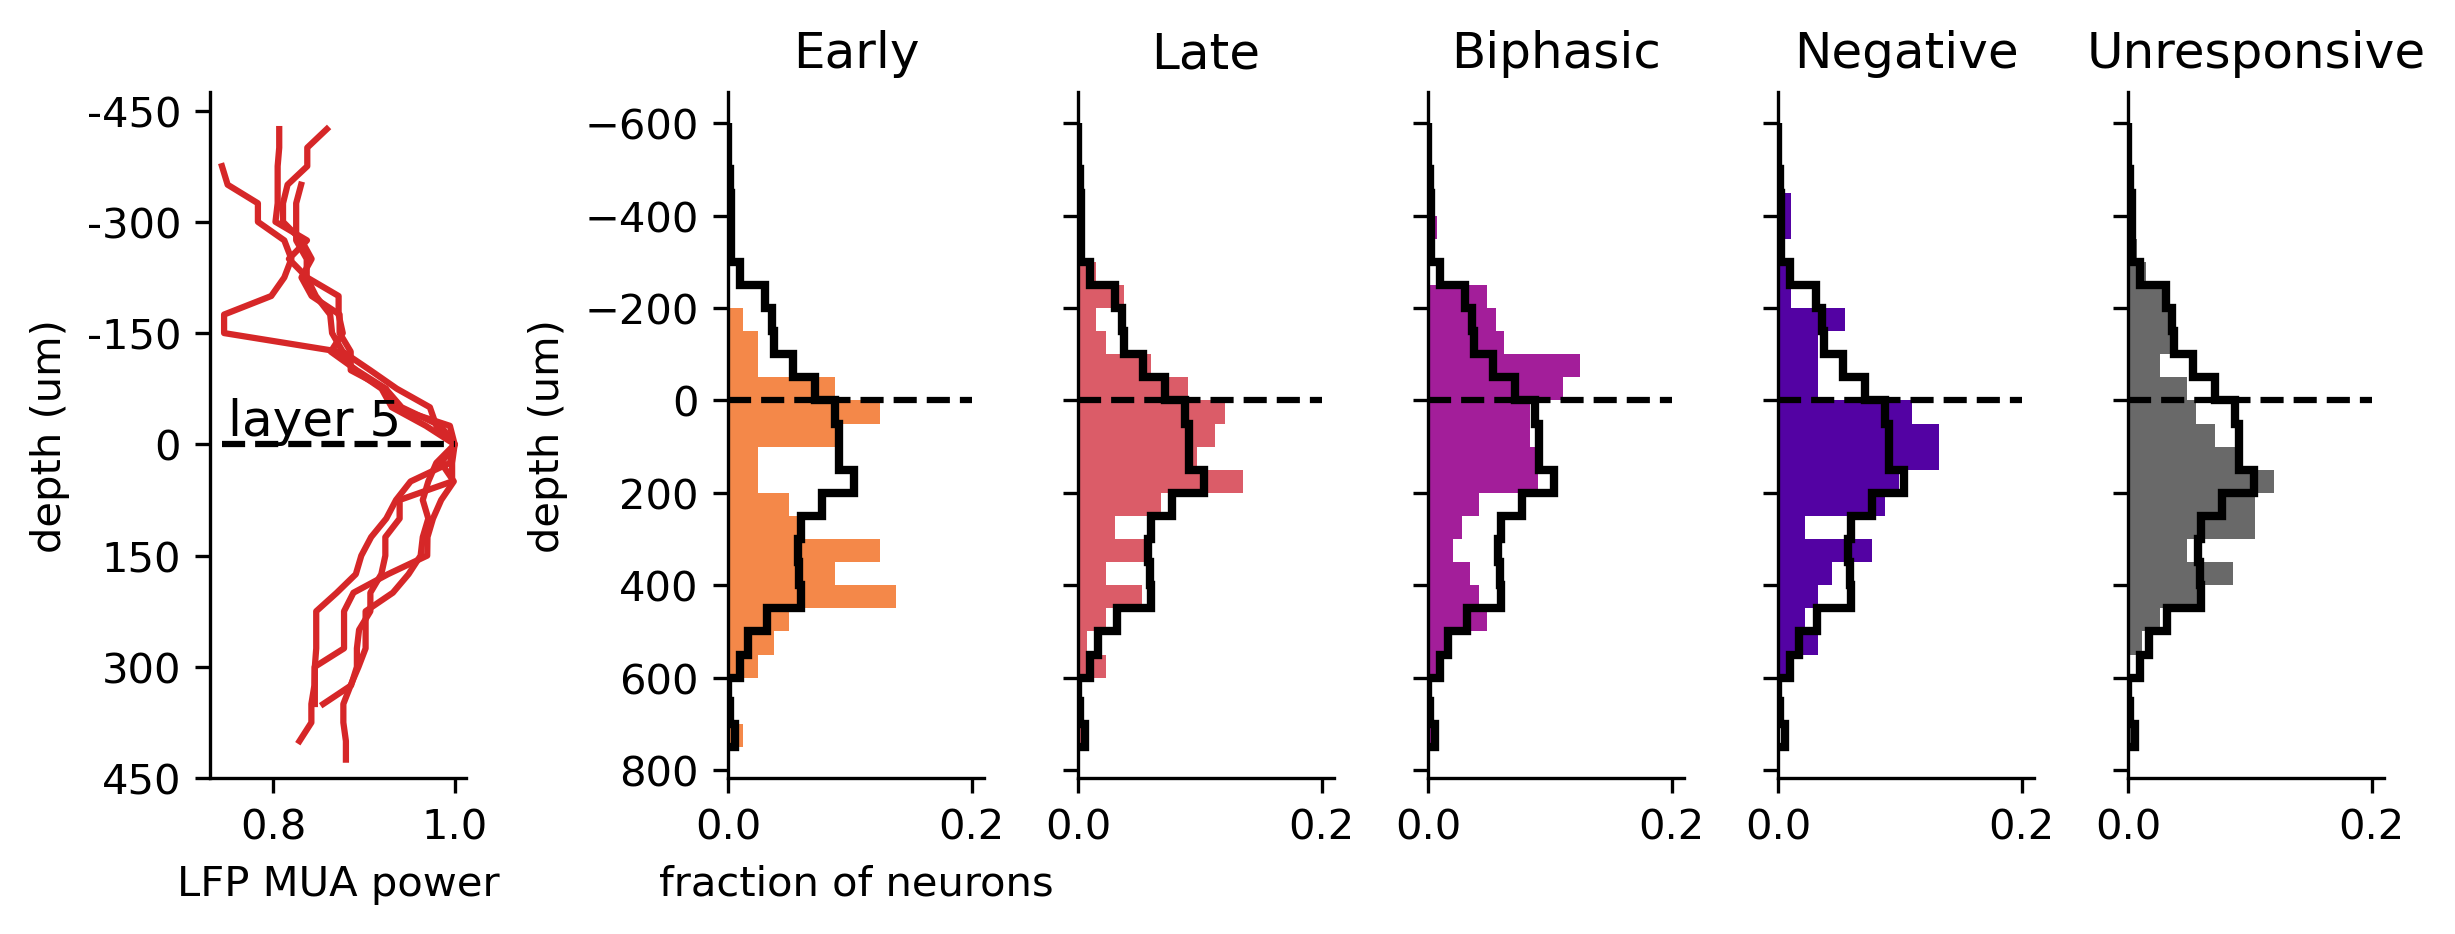

In [54]:
fig2 = plt.figure(constrained_layout=True, figsize=(8,3), dpi=300)
fig2spec = gridspec.GridSpec(nrows=1, ncols=6, figure=fig2, wspace=.1, hspace=0)

ax_ex_depth = fig2.add_subplot(fig2spec[0,0])
ax_early_depth = fig2.add_subplot(fig2spec[0,1])
ax_late_depth = fig2.add_subplot(fig2spec[0,2])
ax_biphasic_depth = fig2.add_subplot(fig2spec[0,3])
ax_negative_depth = fig2.add_subplot(fig2spec[0,4])
ax_unresp_depth = fig2.add_subplot(fig2spec[0,5])

mua_power = hffm['Wn_lfp_power'][hffm['session']=='101521_J559NC_control_Rig2'].iloc[0]
layer5 = hffm['Wn_layer5cent_from_lfp'][hffm['session']=='101521_J559NC_control_Rig2'].iloc[0]
ch_spacing = 25
for sh in range(4):
    ax_ex_depth.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'tab:red')
# ax_ex_depth.set_title('example recording depth')
ax_ex_depth.hlines(0,np.min(mua_power),np.max(mua_power), 'k', linestyle='dashed')
ax_ex_depth.set_ylim([18,-19])
ax_ex_depth.set_yticks(ticks=np.arange(18,-19,-6), labels=(ch_spacing*np.arange(18,-19,-6)))
ax_ex_depth.set_ylabel('depth (um)'); ax_ex_depth.set_xlabel('LFP MUA power')
ax_ex_depth.annotate('layer 5', xy=[0.75, -.5], color='k', fontsize=12)

panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth, ax_unresp_depth]
names = ['early','late','biphasic','negative','unresponsive']

popdata = hffm['Wn_depth_from_layer5'].to_numpy()
pop_weights = np.ones_like(popdata) / float(len(popdata))

for i, panel in enumerate(panels):
    name = names[i]
    panel.hist(popdata, color='k', bins=np.arange(-600,800,50),
               orientation='horizontal',
               histtype='step', linewidth=2, weights=pop_weights)
    
    if i != 4:
        paneldata = hffm['Wn_depth_from_layer5'][hffm['gazecluster']==name][hffm['gazeshift_responsive']].to_numpy()
    else:
        paneldata = hffm['Wn_depth_from_layer5'][hffm['gazecluster']==name].to_numpy()
    panel_weights = np.ones_like(paneldata) / float(len(paneldata))
    
    
    panel.hlines(0, 0, .2, 'k', linestyle='dashed')
    # panel.set_xlim([0,0.3])
    panel.hist(paneldata, color=cat_cmap[name], bins=np.arange(-600,800,50),
               weights=panel_weights, orientation='horizontal', histtype='stepfilled')
    if i==0:
        panel.set_ylabel('depth (um)')
        panel.set_xlabel('fraction of neurons')
    else:
        panel.set_yticklabels([])
        
    panel.set_title(name.capitalize())
    panel.invert_yaxis()
#     panel.set_xlim(0,0.4)

#     panel.set_xticks(np.arange(0.,0.4,.15))
    
fig2.savefig(os.path.join(figpath, 'S1_depth.pdf'))


# Fig 2

## clustering

In [ ]:
hffm['gazecluster'].value_counts()

In [ ]:
for x in ltdk['pref_gazeshift_psth'][ltdk['movement_responsive']==True]:
    plt.plot(psth_bins, x,alpha=0.5)
plt.xlim([-.3,.3]); plt.ylim([-1,1])

In [ ]:
for x in ltdk['pref_dark_gazeshift_psth'][ltdk['movement_responsive']==True]:
    plt.plot(psth_bins, x,alpha=0.5)
plt.xlim([-.3,.3]); plt.ylim([-1,1])

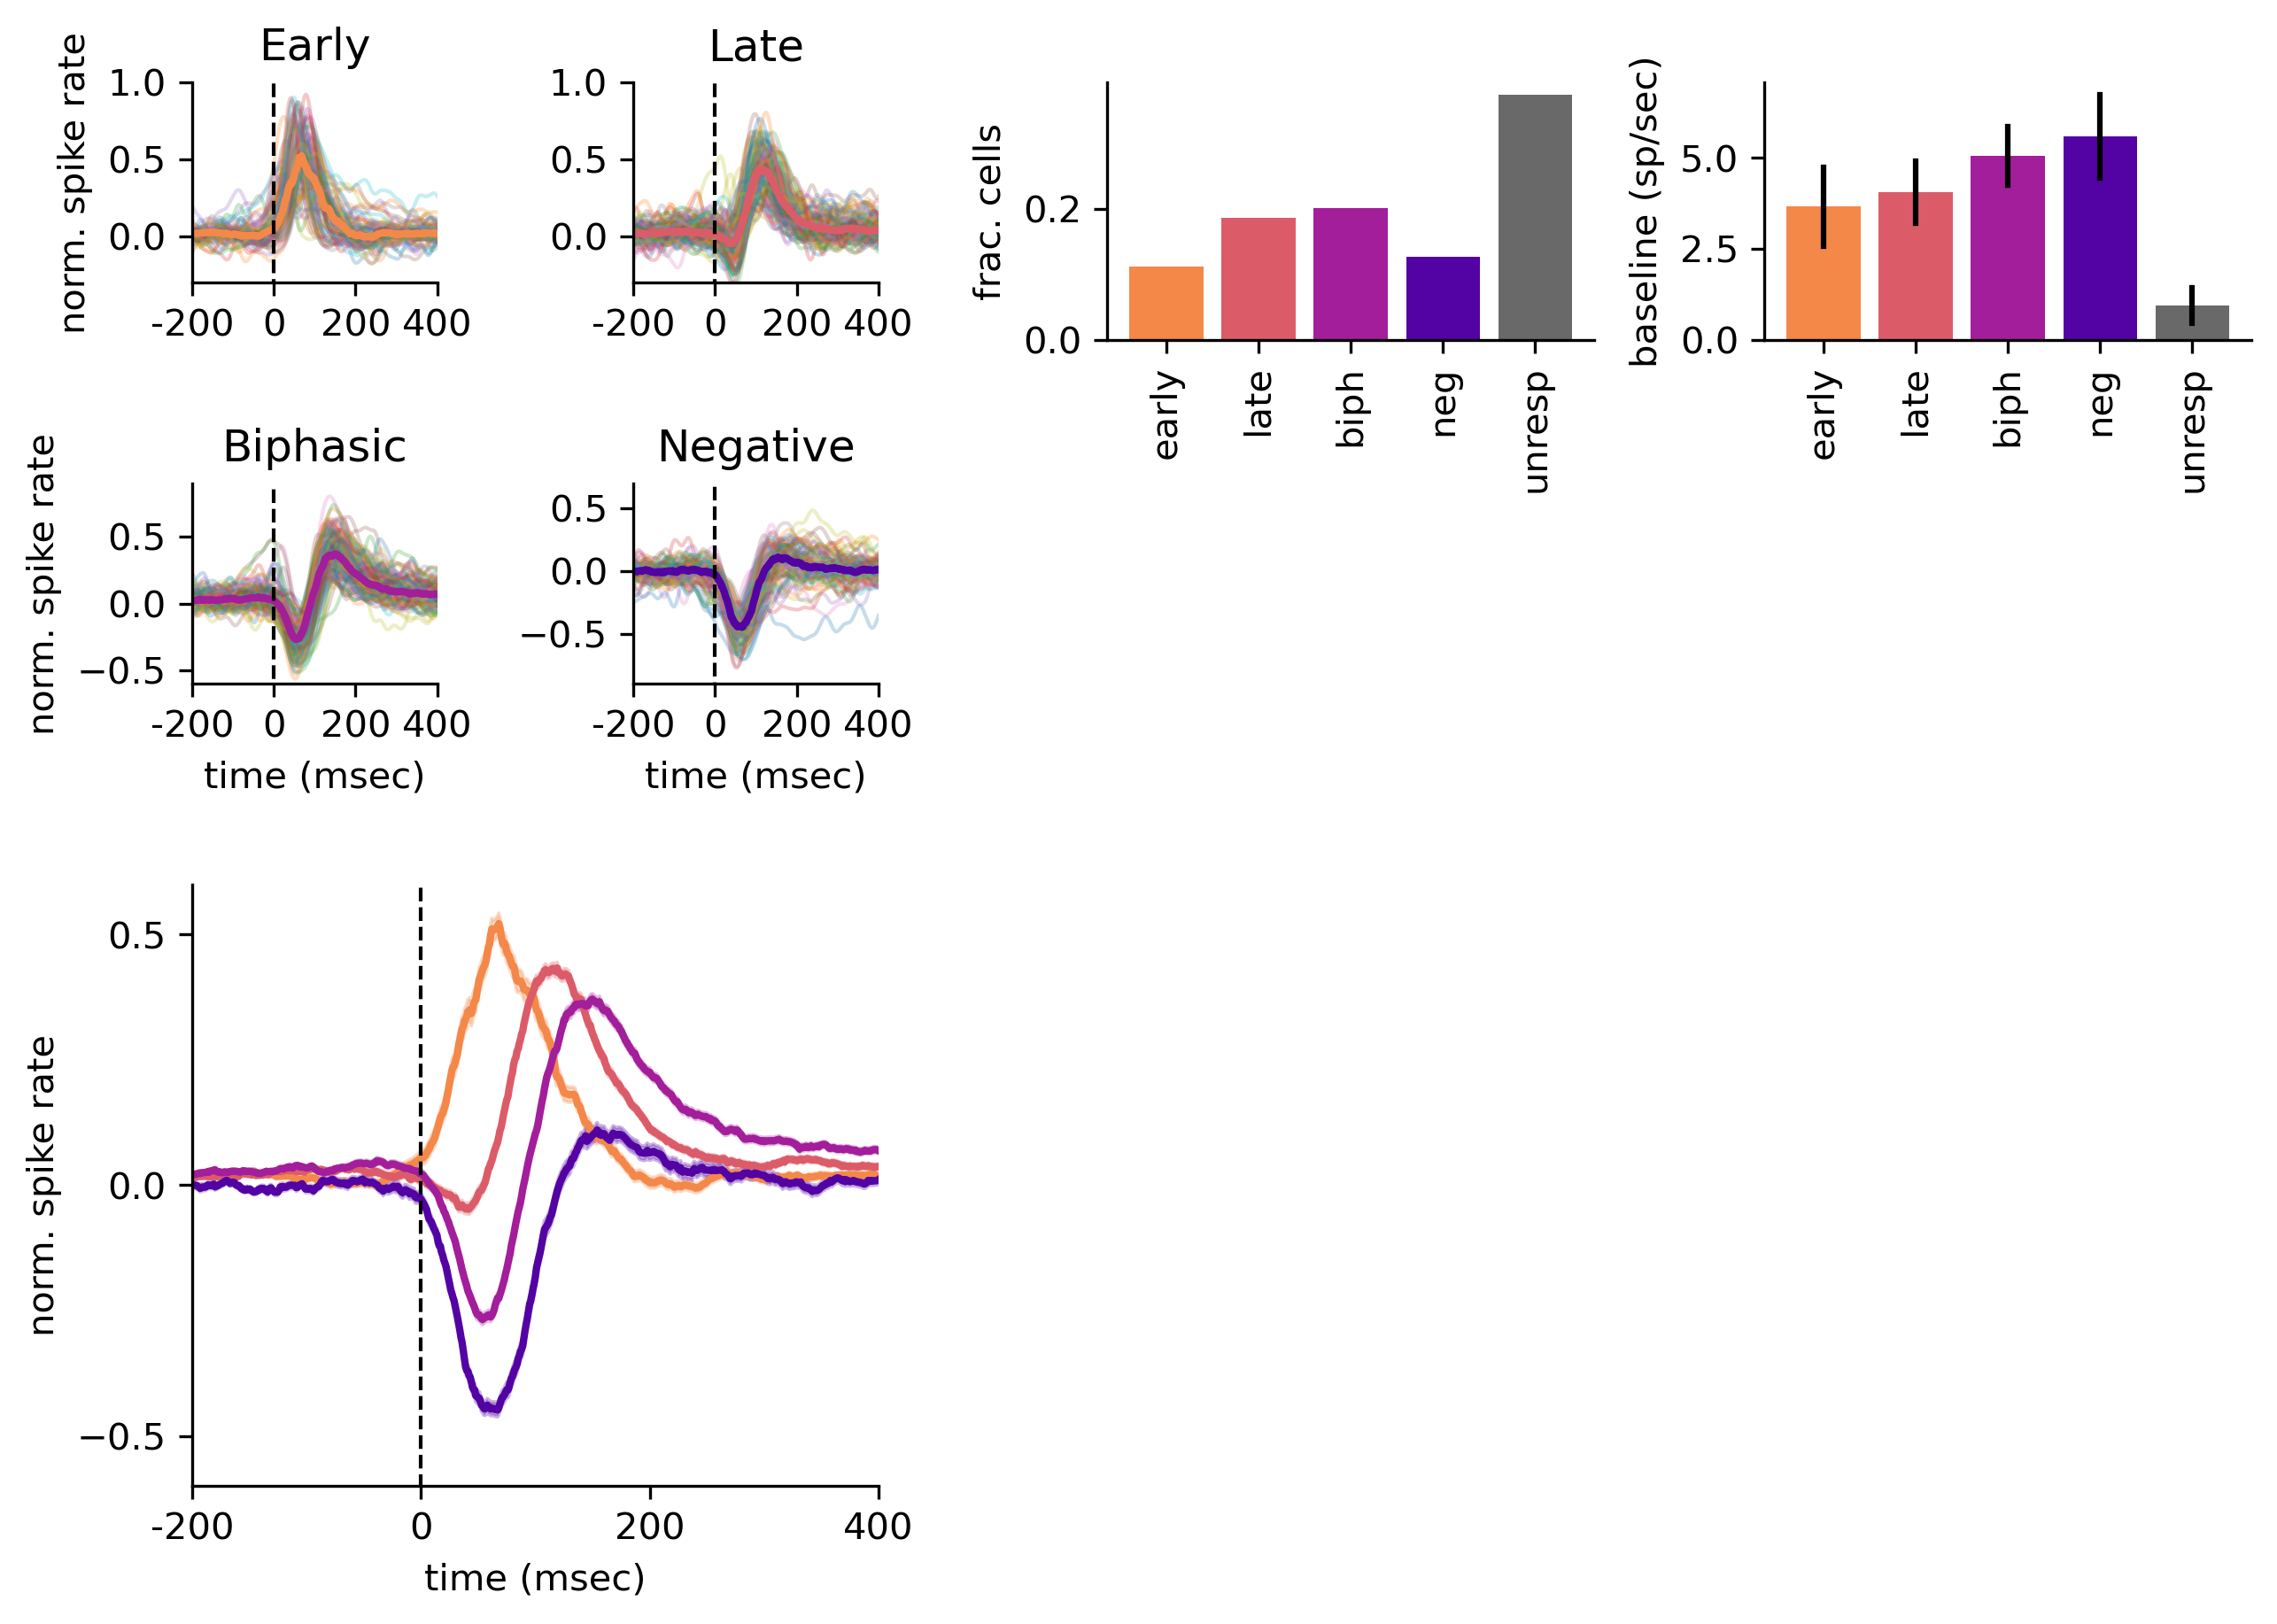

In [64]:
fig2 = plt.figure(constrained_layout=False, figsize=(10,7), dpi=300)
fig2spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig2, wspace=1, hspace=1.2)

fig2Aspec = gridspec.GridSpecFromSubplotSpec(4,2, subplot_spec=fig2spec[:,0:2], wspace=0.8, hspace=1)
ax_early = fig2.add_subplot(fig2Aspec[0,0])
ax_late = fig2.add_subplot(fig2Aspec[0,1])
ax_biphasic = fig2.add_subplot(fig2Aspec[1,0])
ax_negative = fig2.add_subplot(fig2Aspec[1,1])
ax_clusters = fig2.add_subplot(fig2Aspec[2:,:])

fig2B2Dspec = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=fig2spec[0:3,2:], wspace=0.35, hspace=0)
ax_cellcounts = fig2.add_subplot(fig2B2Dspec[0,0])
ax_baseline_fr = fig2.add_subplot(fig2B2Dspec[0,1])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm['pref_gazeshift_psth'][hffm['gazecluster']==movtype][hffm['gazeshift_responsive']]
    for i, psth in enumerate(thisclust):
        panel.plot(psth_bins, psth, '-', linewidth=1, alpha=0.25)
    clustmean = np.nanmedian(flatten_series(thisclust),0)
    panel.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4])
    panel.set_title(movtype.capitalize())
    panel.set_ylim([-1,1])
    if count == 0 or count == 2:
        panel.set_ylabel('norm. spike rate')
#     else:
#         panel.set_yticklabels([])
    if count == 3 or count == 2:
        panel.set_xlabel('time (msec)')
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
#     else:
#         panel.set_xticks([])
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_early.set_ylim([-0.3,1])
ax_late.set_ylim([-0.3,1])
ax_biphasic.set_ylim([-0.6,0.9])
ax_negative.set_ylim([-.9,0.7])

ax_late.set_yticks(np.linspace(0,1,3))
ax_early.set_yticks(np.linspace(0,1,3))
    

step = 0.13
names = ['early','late','biphasic','negative'] # 'unresponsive',
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['pref_gazeshift_psth'][hffm['gazecluster']==name])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.6,.6])
# ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('time (msec)')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

vcounts = hffm['gazecluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
print_names = ['early','late','biph','neg','unresp']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name]/np.sum(vcounts), color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for i, name in enumerate(names):
    baselines = hffm['FmLt_gazeshift_med_baseline'][hffm['gazecluster']==name].to_numpy()
    err = np.std(baselines) / np.sqrt(np.size(baselines))
    med = np.median(baselines)
    ax_baseline_fr.bar(i, med, color=cat_cmap[name])
    ax_baseline_fr.plot([i, i], [med-err, med+err], 'k-')
ax_baseline_fr.set_xticks(range(5), print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/sec)')

# plot_cprop_scatter(ax_baseline_fr, 'psth_baseline', use_median=True)
# ax_baseline_fr.set_ylabel('baseline (sp/sec)')
# ax_baseline_fr.set_ylim([0,50])

fig2.savefig(os.path.join(figpath, '2_clustering_noUnresp.pdf'))

## comp clusters

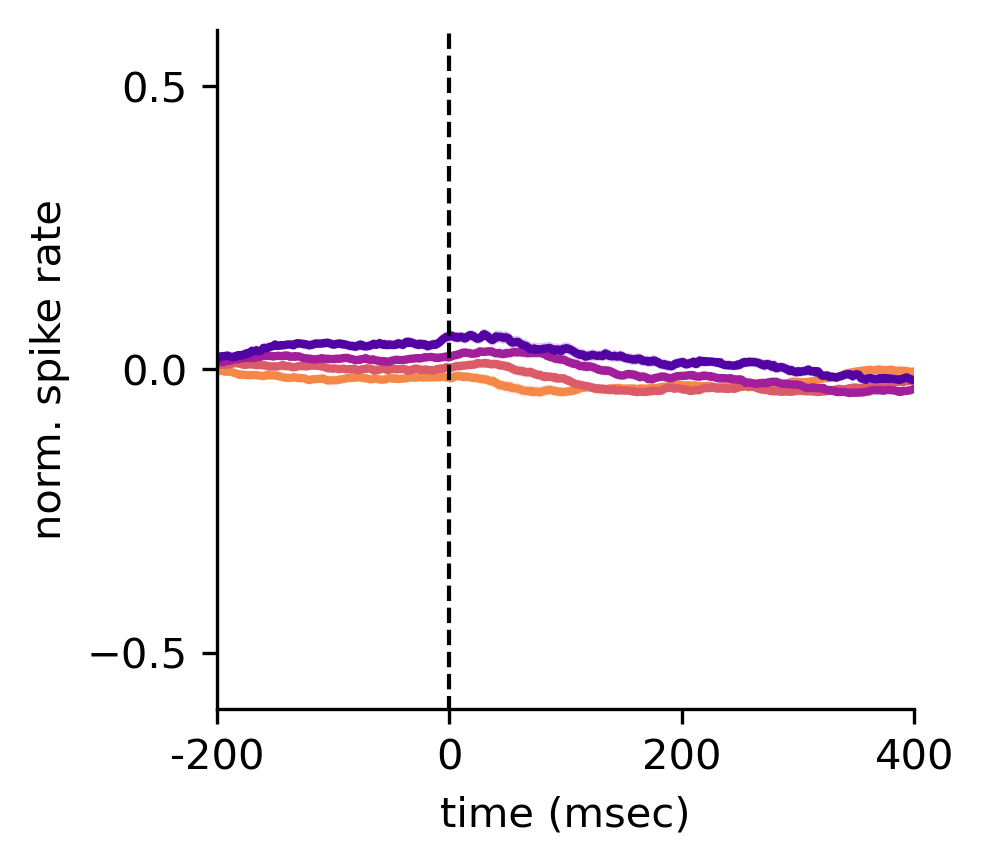

In [67]:
fig, ax_clusters = plt.subplots(1,1,figsize=(3,3), dpi=300)

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['pref_comp_psth'][hffm['gazecluster']==name][hffm['gazeshift_responsive']])
    cluster_psths = drop_nan_along(cluster_psths)
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.6,.6])
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('time (msec)')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

fig.savefig(os.path.join(figpath, '2_comp_by_cluster_noUnresp.pdf'))

## Fig 2: temporal sequences

In [68]:
num_responsive = len(hffm[hffm['gazecluster']!='unresponsive'][hffm['gazeshift_responsive']==True][hffm['movement']==False].to_numpy())
num_responsive

448

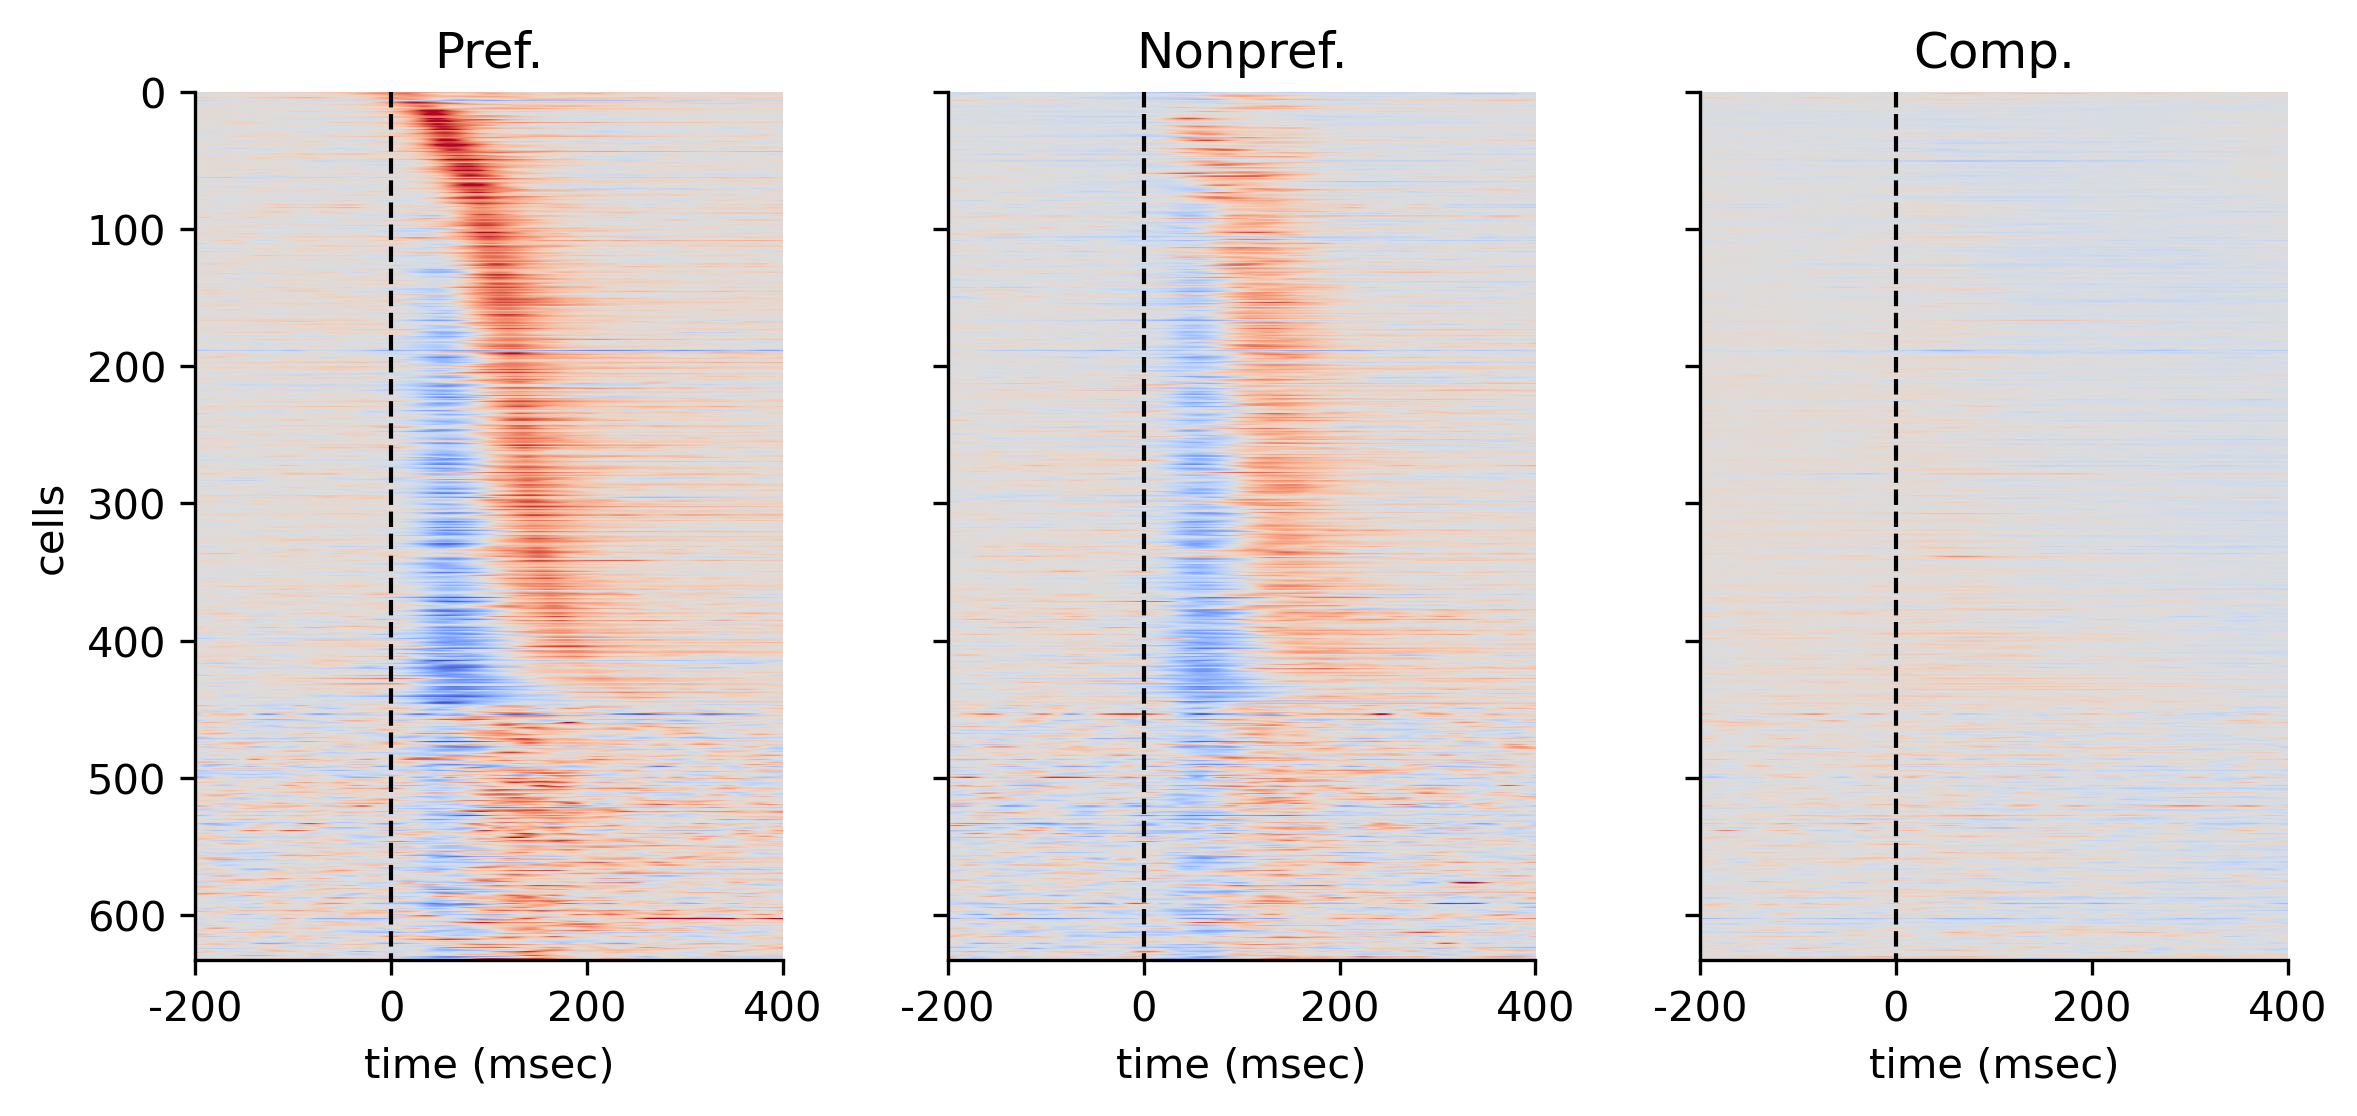

In [73]:
fig2p2 = plt.figure(constrained_layout=False, figsize=(9,5), dpi=300)

fig2p2A = gridspec.GridSpec(1,3, figure=fig2p2, wspace=.28, hspace=.1)
ax_tseq_pref = fig2p2.add_subplot(fig2p2A[:,0])
ax_tseq_nonpref = fig2p2.add_subplot(fig2p2A[:,1])
ax_tseq_comp = fig2p2.add_subplot(fig2p2A[:,2])

tseq_aspect = 1.4
img = plot_tempseq(ax_tseq_pref, tseq_pref1, return_img=True)
ax_tseq_pref.set_aspect(tseq_aspect)
ax_tseq_pref.set_title('Pref.')
ax_tseq_pref.set_ylabel('cells')
# ax_tseq_pref.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax_tseq_nonpref, tseq_nonpref1)
ax_tseq_nonpref.set_aspect(tseq_aspect)
ax_tseq_nonpref.set_title('Nonpref.')
ax_tseq_nonpref.set_yticklabels([])
# ax_tseq_nonpref.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax_tseq_comp, tseq_comp1)
ax_tseq_comp.set_aspect(tseq_aspect)
ax_tseq_comp.set_title('Comp.')
ax_tseq_comp.set_yticklabels([])
# ax_tseq_comp.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

fig2p2.savefig(os.path.join(figpath, '2_temporal_seq.pdf'))

## Fig 2 temp seq scale bar

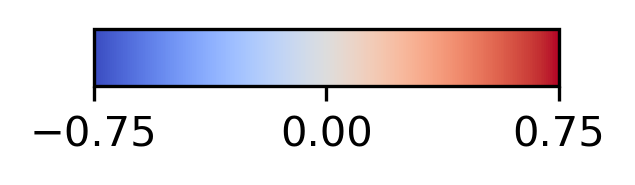

In [72]:
fig, ax = plt.subplots(figsize=(2,.25), dpi=300)
plt.colorbar(img, cax=ax, aspect=10, orientation='horizontal')
plt.xticks(np.linspace(-0.75,0.75,3))
# ax.xaxis.set_tick_params(width=2)
plt.savefig(os.path.join(figpath, '2_seq_legend.pdf'), bbox_inches='tight', pad_inches=.5)

# Fig 3

## ltdk temp seq

In [108]:
ltdk.drop(index=247, inplace=True)

In [120]:
for ind in ltdk.index.values:
    Lt_peakT, Lt_peakVal = calc_latency(ltdk.loc[ind,'pref_gazeshift_psth'])
    
    ltdk.at[ind, 'FmLt_gazeshift_peakT'] = Lt_peakT

In [121]:
for ind in ltdk.index.values:
    sorted_df = ltdk[['FmLt_gazeshift_peakT','FmDk_gazeshift_peakT','FmLt_gazeshift_troughT','FmDk_gazeshift_troughT','gazecluster',
                           'pref_gazeshift_psth','pref_dark_gazeshift_psth','nonpref_dark_gazeshift_psth','gazeshift_responsive',
                          'pref_dark_comp_psth']].copy()

# shuffle unresponsive cells
tseq_unresp = sorted_df.copy()
tseq_unresp = tseq_unresp[tseq_unresp['gazecluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_l_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth'].copy())
tseq_d_unresp = flatten_series(tseq_unresp['pref_dark_gazeshift_psth'].copy())
    
# sort dark by dark times
tseq_dark_sort = sorted_df.copy()
tseq_dark_sort = tseq_dark_sort[tseq_dark_sort['gazecluster']!='unresponsive'][tseq_dark_sort['gazeshift_responsive']]
tseq_dark_sort.sort_values(by='FmDk_gazeshift_peakT', inplace=True)

tseq_dark_by_dark = np.vstack([flatten_series(tseq_dark_sort['pref_dark_gazeshift_psth'].copy()), tseq_d_unresp])

# sort light/dark by light times
sort_by_light = sorted_df.copy()
sort_by_light = sort_by_light[sort_by_light['gazecluster']!='unresponsive']
sort_by_light.sort_values(by='FmLt_gazeshift_peakT', inplace=True)

tseq_light = flatten_series(sort_by_light['pref_gazeshift_psth'].copy())
tseq_dark_pref = flatten_series(sort_by_light['pref_dark_gazeshift_psth'].copy())
tseq_dark_nonpref = flatten_series(sort_by_light['nonpref_dark_gazeshift_psth'].copy())
tseq_dark_comp = flatten_series(sort_by_light['pref_dark_comp_psth'].copy())

tseq_light1 = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth'].copy()), tseq_l_unresp])
tseq_dark_pref1 = np.vstack([flatten_series(sort_by_light['pref_dark_gazeshift_psth'].copy()), tseq_d_unresp])
tseq_dark_nonpref1 = np.vstack([flatten_series(sort_by_light['nonpref_dark_gazeshift_psth'].copy()), tseq_d_unresp])
tseq_dark_comp1 = np.vstack([flatten_series(sort_by_light['pref_dark_comp_psth'].copy()), tseq_d_unresp])

In [122]:
num_responsive = len(ltdk[ltdk['gazecluster']!='unresponsive'][ltdk['gazeshift_responsive']==True][ltdk['movement']==False].to_numpy())
num_responsive

190

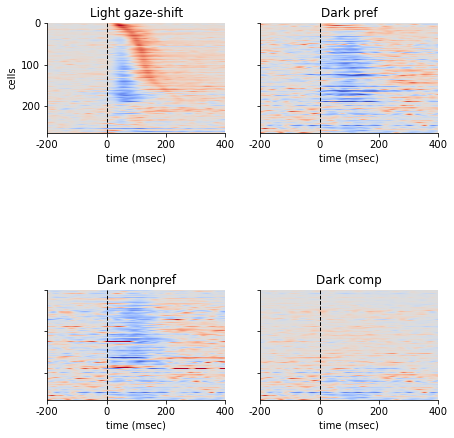

In [125]:
tseq_aspect = 1.4

fig, axs = plt.subplots(2,2,figsize=(7,9))
ax0, ax1, ax2, ax3 = axs.flatten()

plot_tempseq(ax0, tseq_light1)
ax0.set_aspect(tseq_aspect)
ax0.set_title('Light gaze-shift')
ax0.set_ylabel('cells')
# ax0.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax1, tseq_dark_pref1)
ax1.set_aspect(tseq_aspect)
ax1.set_title('Dark pref')
ax1.set_yticklabels([])
# ax1.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax2, tseq_dark_nonpref1)
ax2.set_aspect(tseq_aspect)
ax2.set_title('Dark nonpref')
ax2.set_yticklabels([])
# ax2.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

plot_tempseq(ax3, tseq_dark_comp1)
ax3.set_aspect(tseq_aspect)
ax3.set_title('Dark comp')
ax3.set_yticklabels([])
# ax3.hlines(num_responsive, 800,1400,'k',linestyle='dashed', linewidth=1)

fig.savefig(os.path.join(figpath, '3_temporal_seq.pdf'))

In [ ]:
np.argmin(np.sum(tseq_dark_nonpref1,1))

196

## ltdk clustering

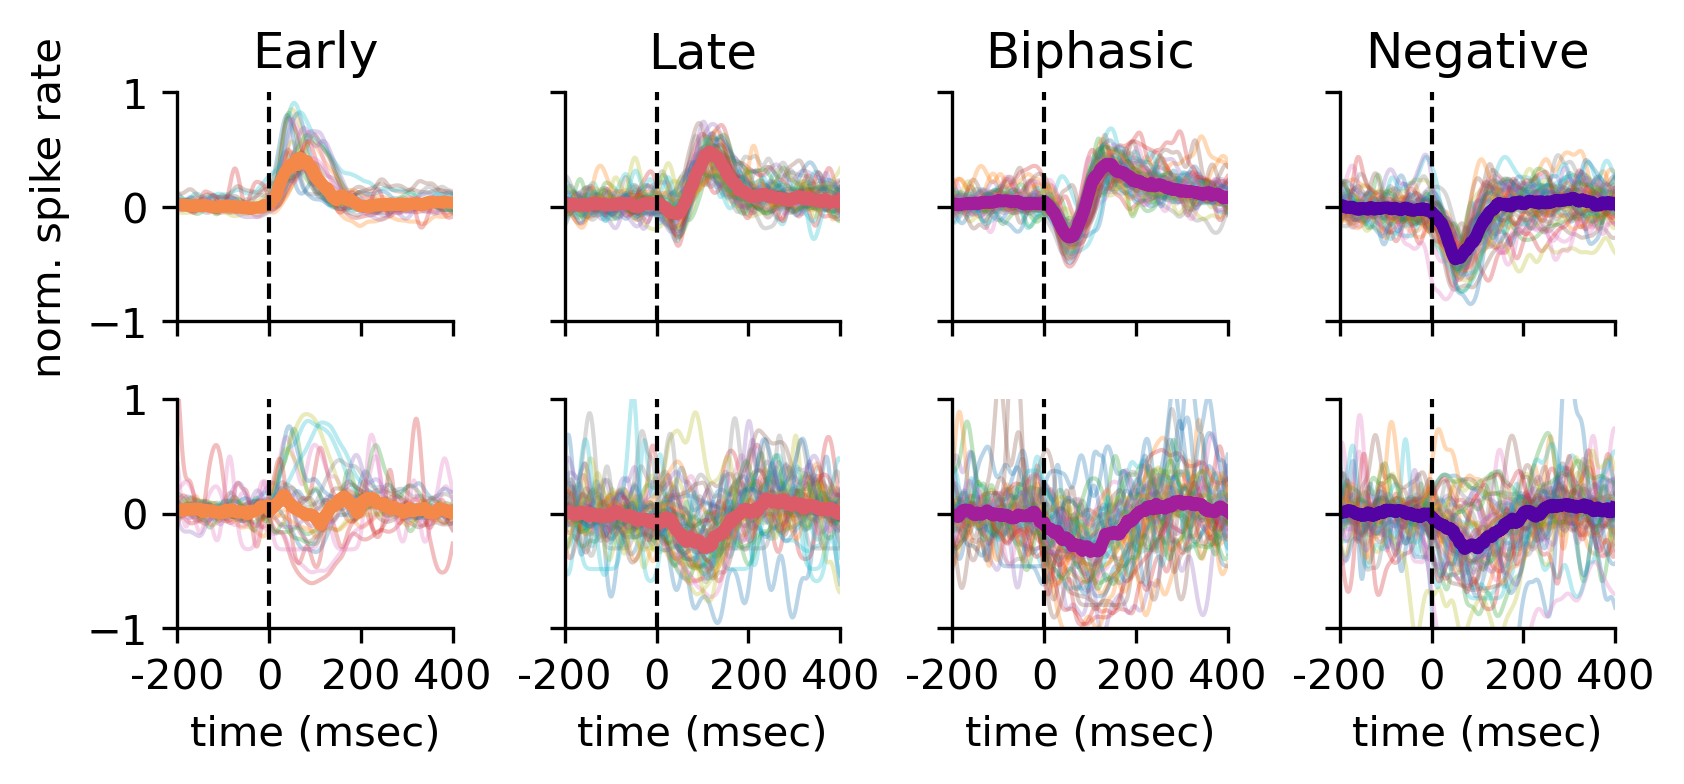

In [126]:
fig3A = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig3A, wspace=0.05, hspace=0.1)

ax_early_l = fig3A.add_subplot(fig3Aspec[0,0])
ax_late_l = fig3A.add_subplot(fig3Aspec[0,1])
ax_biphasic_l = fig3A.add_subplot(fig3Aspec[0,2])
ax_negative_l = fig3A.add_subplot(fig3Aspec[0,3])

ax_early_d = fig3A.add_subplot(fig3Aspec[1,0])
ax_late_d = fig3A.add_subplot(fig3Aspec[1,1])
ax_biphasic_d = fig3A.add_subplot(fig3Aspec[1,2])
ax_negative_d = fig3A.add_subplot(fig3Aspec[1,3])

names = ['early','late','biphasic','negative']
light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk['pref_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True][ltdk['movement']==False]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-1,1])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk['pref_dark_gazeshift_psth'][ltdk['gazecluster']==name][ltdk['gazeshift_responsive']==True][ltdk['movement']==False]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-1,1])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':
        lpanel.set_ylabel('norm. spike rate')
        # dpanel.set_ylabel('norm. spike rate')
    if name!='early':
        lpanel.set_yticklabels([])
        dpanel.set_yticklabels([])
    lpanel.set_xticklabels([])
    dpanel.set_xlabel('time (msec)')
    lpanel.set_title(name.capitalize())
        
fig3A.savefig(os.path.join(figpath, '3_clustering.pdf'))

## ltdk cluster summary

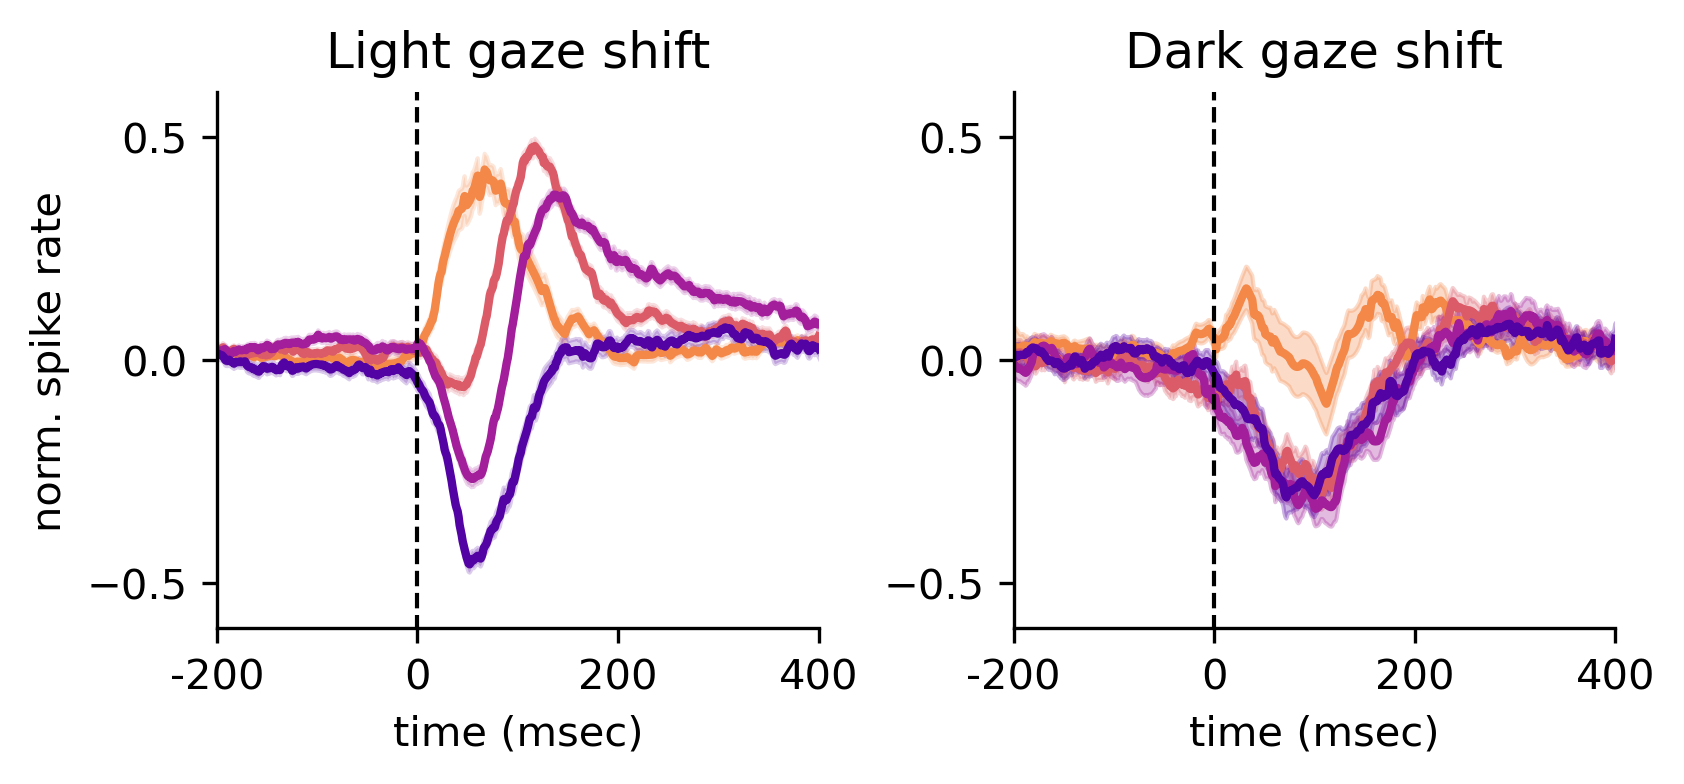

In [114]:
fig3B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.6,.6])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('time (msec)')
ax_light_clusters.set_title('Light gaze shift')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_dark_gazeshift_psth'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.6,.6]); ax_dark_clusters.set_xlabel('time (msec)')
ax_dark_clusters.set_title('Dark gaze shift')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig(os.path.join(figpath, '3_cluster_summary_noUnresp.pdf'))

## ltdk comp summary

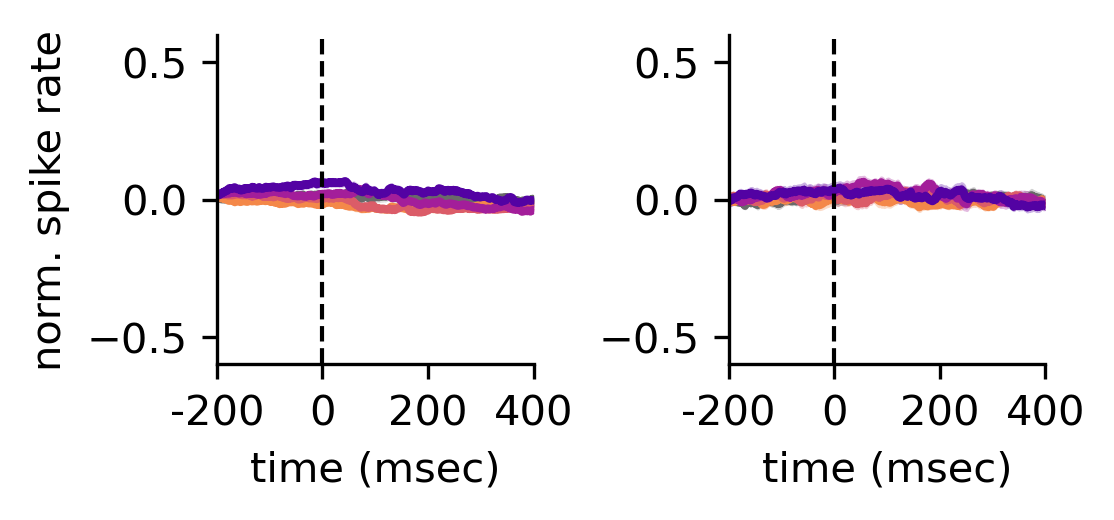

In [117]:
fig3B = plt.figure(constrained_layout=True, figsize=(3.6,1.6), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['unresponsive','early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth'][ltdk['movement']==False])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.6,.6])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('time (msec)')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk[ltdk['gazecluster']==name]
    cluster_psths = flatten_series(data['pref_dark_comp_psth'][ltdk['movement']==False])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.6,.6]); ax_dark_clusters.set_xlabel('time (msec)')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig(os.path.join(figpath, '3_comp_summary.pdf'))

## temp seq legned

In [127]:
tseq_legend_col = sort_by_light['gazecluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
u = np.zeros([np.size(tseq_l_unresp,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend1 = np.vstack([tseq_legend, u])

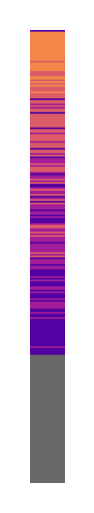

In [128]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '3_temp_seq_legend.pdf'))

## dark responsive

In [129]:
for ind, row in ltdk[['pref_dark_gazeshift_psth','pref_gazeshift_psth']].iterrows():
    r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['pref_dark_gazeshift_psth'].astype(float)[1000:1250])
    ltdk.at[ind, 'gaze_ltdk_maxcc'] = r[0,1]

In [142]:
for ind, row in ltdk.iterrows():
    # firing rate
    sec = row['FmDk_eyeT'][-1].astype(float) - row['FmDk_eyeT'][0].astype(float)
    sp = len(row['FmDk_spikeT'])
    fm_fr = sp/sec
    ltdk.at[ind, 'FmDk_fr'] = fm_fr
    
    ltdk.at[ind, 'norm_mod_at_pref_peak_dark'] = psth_modind(row['pref_dark_gazeshift_psth'])
    
    ltdk.at[ind, 'raw_mod_at_pref_peak_dark'] = psth_modind(row['pref_dark_gazeshift_psth_raw'])
    
    ltdk.at[ind, 'norm_mod_at_pref_peak'] = psth_modind(row['pref_gazeshift_psth'])
    
    ltdk.at[ind, 'raw_mod_at_pref_peak'] = psth_modind(row['pref_gazeshift_psth_raw'])

In [137]:
def calc_psth_DSI(pref, nonpref):
    
    prefmod = psth_modind(pref)
    nonprefmod = psth_modind(nonpref)
    
    mod = (prefmod - nonprefmod) / (prefmod + nonprefmod)
    
    return mod

In [358]:
ltdk['dark_responsive'] = False
for ind, row in ltdk.iterrows():
    if (row['norm_mod_at_pref_peak_dark']>0.1) and (row['raw_mod_at_pref_peak_dark']>1):
        ltdk.at[ind, 'dark_responsive'] = True

(array([ 2.,  0.,  6.,  2., 45., 82., 63., 31., 21., 13.]),
 array([-0.67330822, -0.5177697 , -0.36223118, -0.20669266, -0.05115414,
         0.10438438,  0.25992291,  0.41546143,  0.57099995,  0.72653847,
         0.88207699]),
 <BarContainer object of 10 artists>)

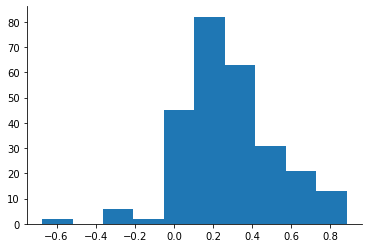

In [357]:
plt.hist(ltdk['FmDk_gazeshift_peak_val'])

In [143]:
ltdk['FmLt_gaze_DSI'] = False
ltdk['FmLt_gaze_responsive'] = False

for ind, row in ltdk.iterrows():
    if (row['raw_mod_at_pref_peak']>1) and (row['norm_mod_at_pref_peak']>0.1):
        mod = calc_psth_DSI(row['pref_gazeshift_psth'], row['nonpref_gazeshift_psth'])
        ltdk.at[ind, 'FmLt_gaze_DSI'] = mod
        ltdk.at[ind, 'FmLt_gaze_responsive'] = True

In [147]:
len(ltdk[ltdk['FmLt_gaze_DSI']>0.5].index.values)

12

## ltdk firing rates

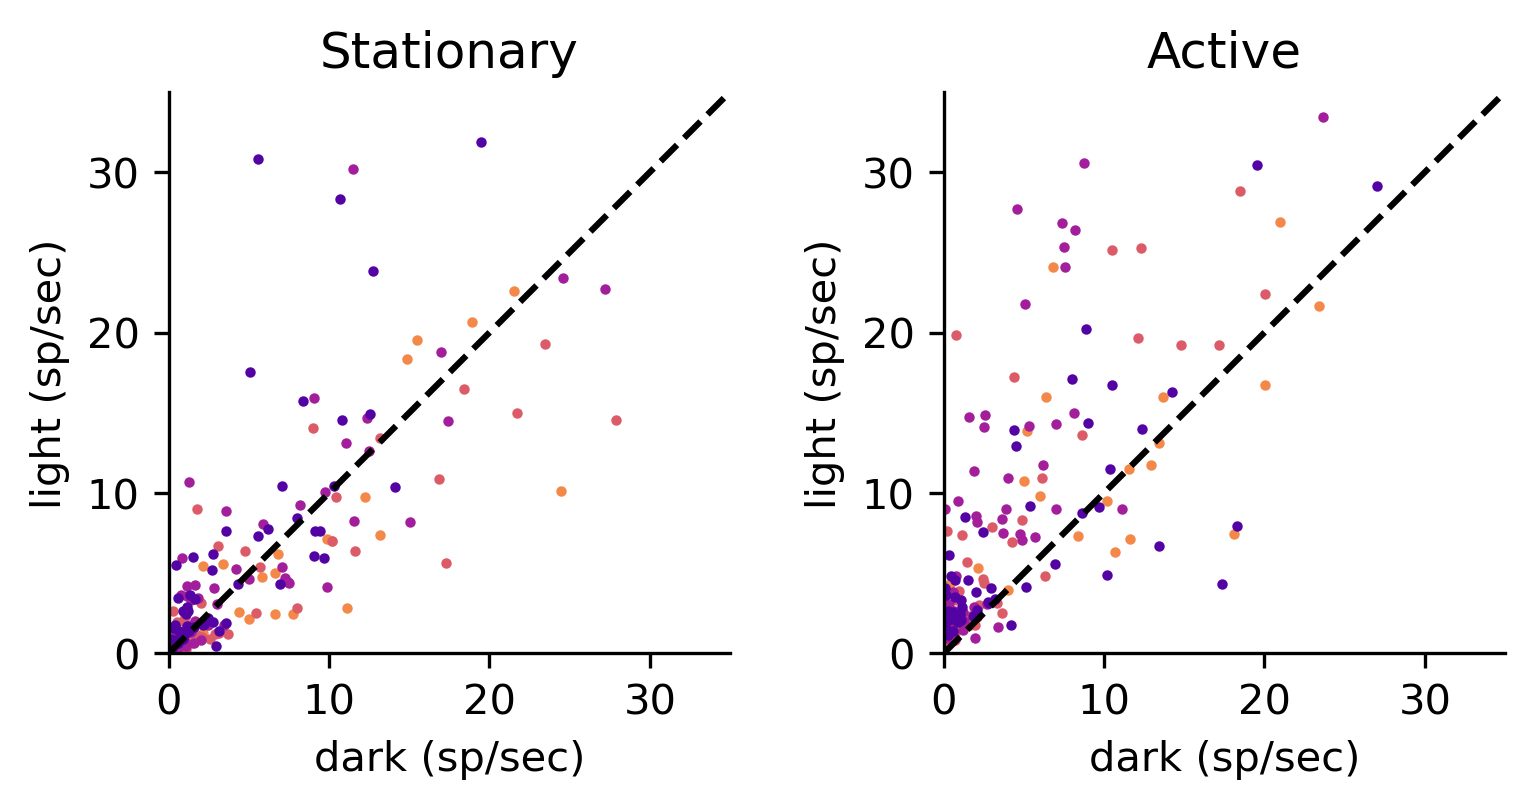

In [141]:
names = ['early','late','biphasic','negative']

fig3E = plt.figure(constrained_layout=True, figsize=(5,6), dpi=300)
fig3Espec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig3E, wspace=.3, hspace=0.5)

ax_stationary_fr = fig3E.add_subplot(fig3Espec[1:3,0:3])
ax_active_fr = fig3E.add_subplot(fig3Espec[1:3,3:6])

for name in names:
    light_iafr = ltdk['FmLt_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_iafr = ltdk['FmDk_inactive_fr'][ltdk['gazecluster']==name].to_numpy()
    
    light_afr = ltdk['FmLt_active_fr'][ltdk['gazecluster']==name].to_numpy()
    dark_afr = ltdk['FmDk_active_fr'][ltdk['gazecluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_active_fr.plot(dark_afr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
        ax_stationary_fr.plot(dark_iafr[i], light_iafr[i], '.', color=cat_cmap[name], markersize=3)
    
fr_axis_max = 35
ax_active_fr.axis('square')
ax_stationary_fr.axis('square')
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_active_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('dark (sp/sec)'); ax_stationary_fr.set_ylabel('light (sp/sec)')
ax_active_fr.set_title('Active')
ax_active_fr.set_xlabel('dark (sp/sec)'); ax_active_fr.set_ylabel('light (sp/sec)')
ax_stationary_fr.set_title('Stationary')
ax_active_fr.set_xticks(np.arange(0,35,10))
ax_stationary_fr.set_yticks(np.arange(0,35,10))
ax_active_fr.set_xticks(np.arange(0,35,10))
ax_stationary_fr.set_yticks(np.arange(0,35,10))


fig3E.savefig(os.path.join(figpath, '3_ltdk_firing_rates.pdf'))

## dark responsive PSTHs

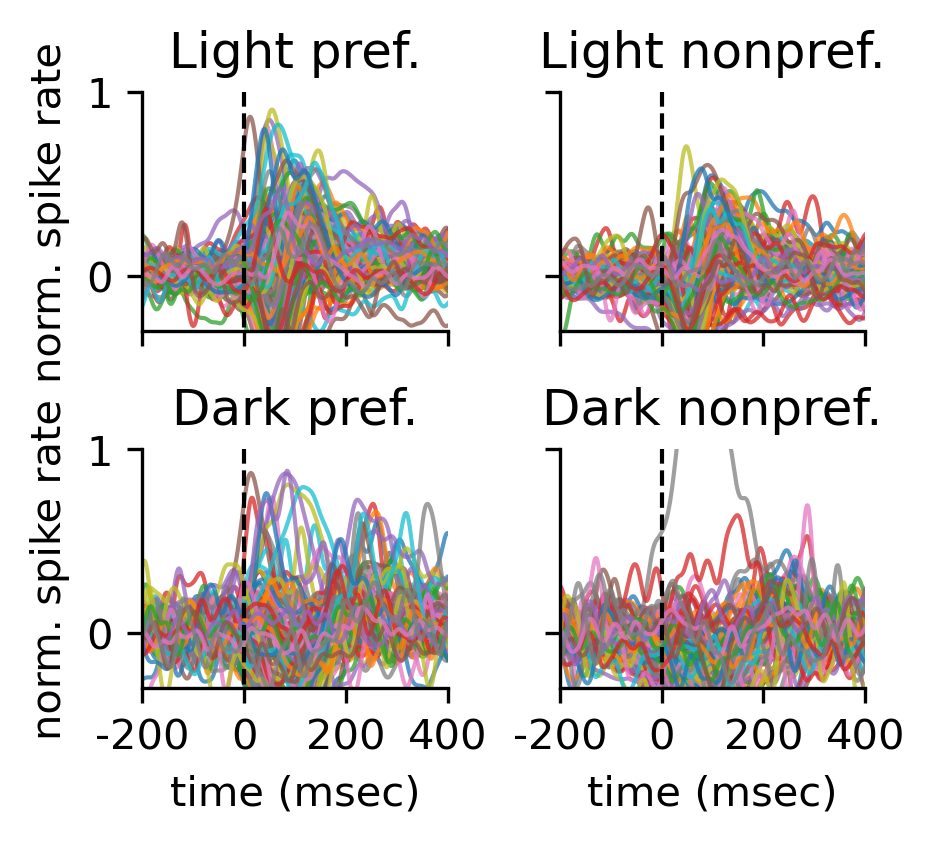

In [337]:
fig3A = plt.figure(constrained_layout=True, figsize=(3,2.7), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig3A, wspace=0.05, hspace=0.1)

ax_light_pref = fig3A.add_subplot(fig3Aspec[0,0])
ax_light_nonpref = fig3A.add_subplot(fig3Aspec[0,1])
ax_dark_pref = fig3A.add_subplot(fig3Aspec[1,0])
ax_dark_nonpref = fig3A.add_subplot(fig3Aspec[1,1])

names = ['pref_gazeshift_psth','nonpref_gazeshift_psth','pref_dark_gazeshift_psth','nonpref_dark_gazeshift_psth']
panels = [ax_light_pref, ax_light_nonpref, ax_dark_pref, ax_dark_nonpref]
use_cells = ltdk[ltdk['FmLt_gaze_responsive']][ltdk['dark_responsive']].copy()

ax_light_pref.set_title('Light pref.')
ax_light_nonpref.set_title('Light nonpref.')
ax_dark_pref.set_title('Dark pref.')
ax_dark_nonpref.set_title('Dark nonpref.')

for count, name in enumerate(names):
    panel = panels[count]
    
    for x in use_cells[name]:
        panel.plot(psth_bins, x, '-', linewidth=1, alpha=.75)
    # panel.plot(psth_bins, np.nanmedian(flatten_series(use_cells['pref_gazeshift_psth']),0), '-', linewidth=2, color='k')
    panel.set_xlim([-0.2,0.4]); panel.set_ylim([-1,1])
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    panel.set_ylim([-.3,1])
    if count==0 or count==1:
        panel.set_xticklabels([])
    else:
        panel.set_xlabel('time (msec)')
        
    if count==1 or count==3:
        panel.set_yticklabels([])
    else:
        panel.set_ylabel('norm. spike rate')
    # if name=='early':
    #     lpanel.set_ylabel('norm. spike rate')
    # if name!='early':
    #     lpanel.set_yticklabels([])
    #     dpanel.set_yticklabels([])
    # lpanel.set_xticklabels([])
    # dpanel.set_xlabel('time (msec)')
        
fig3A.savefig(os.path.join(figpath, 'S3_dark_responsive.pdf'))

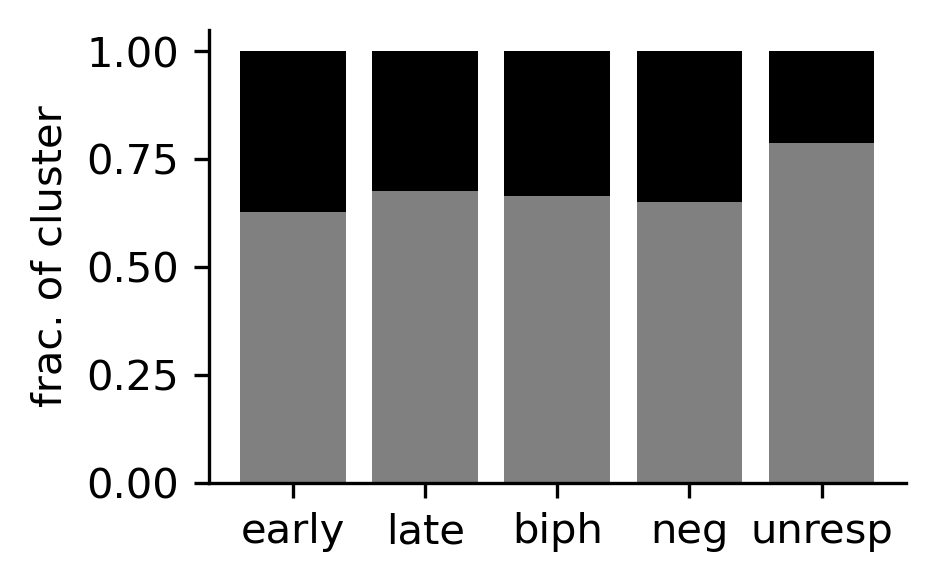

In [150]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(3,2))
for i, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    vcounts = hffm['exc_or_inh'][hffm['gazecluster']==name].value_counts()
    ax.bar(i, vcounts['exc']/np.sum(vcounts), color='grey')
    ax.bar(i, vcounts['inh']/np.sum(vcounts), bottom=vcounts['exc']/np.sum(vcounts), color='k')
ax.set_xticks(ticks=range(5), labels=['early','late','biph','neg','unresp'])
ax.set_ylabel('frac. of cluster')
fig.savefig(os.path.join(figpath, 'S2_celltype.pdf'))

# direction selectivity hist

In [151]:
for ind, row in hffm.iterrows():
    hffm.at[ind, 'gazeshift_DSI'] = calc_psth_DSI(row['pref_gazeshift_psth_raw'].astype(float), row['nonpref_gazeshift_psth_raw'].astype(float))

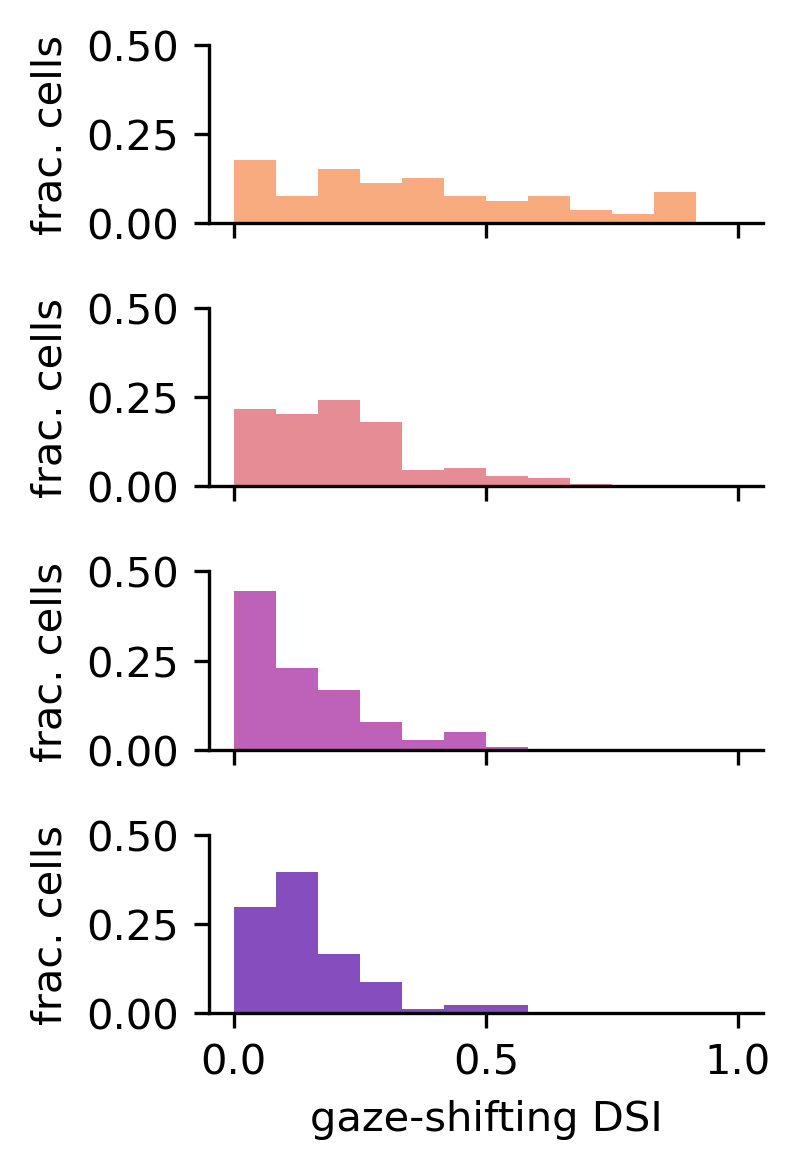

In [152]:
fig, axs = plt.subplots(4,1,figsize=(2.8,4),dpi=300)

for p, name in enumerate(['early','late','biphasic','negative']):
    ax = axs[p]
    
    vals = hffm['gazeshift_DSI'][hffm['gazecluster']==name].copy()
    weights = np.ones_like(vals) / float(len(vals))
    ax.hist(vals, bins=np.linspace(0,1,13),weights=weights,
             color=cat_cmap[name], histtype='stepfilled', alpha=0.7)
    ax.set_ylim([0,.5])
    if p==3:
        # ax.set_title(name)
        ax.set_xlabel('gaze-shifting DSI')
    else:
        ax.set_xticklabels([])
    ax.set_ylabel('frac. cells')
    
plt.tight_layout()
fig.savefig(os.path.join(figpath, 'S_gaze_DSI.pdf'))

# Umap for supp

In [ ]:
import umap
reducer = umap.UMAP()
gazeshift_arr = flatten_series(hffm['pref_gazeshift_psth'])
embedding = reducer.fit_transform(gazeshift_arr)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
for count, movtype in enumerate(['early','late','biphasic','negative','unresponsive']):
    inds = hffm[hffm['gazecluster']==movtype].index.values
    ax.plot(embedding[inds,0], embedding[inds,1], '.', color=cat_cmap[movtype], markersize=8)
    ax.set_title('UMAP Embedding')
fig.savefig('/home/niell_lab/Desktop/umap.pdf')

# Plot PCA

In [158]:
from scipy.stats import zscore

In [217]:
proj = np.load('/home/niell_lab/Desktop/dEye_PSTH_pca1.npy')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

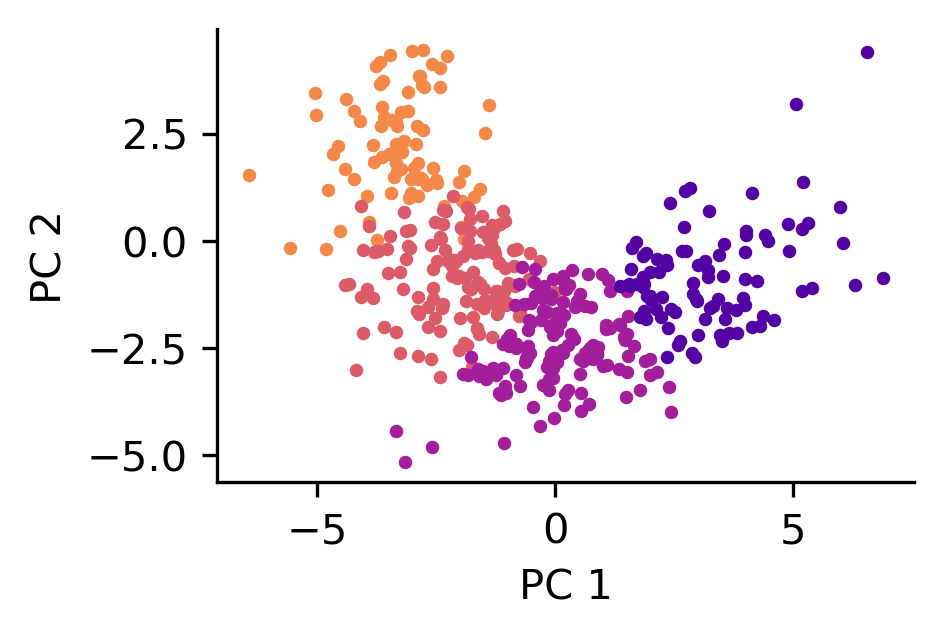

In [226]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for name in ['early','late','biphasic','negative']:
    use = np.array([hffm['gazecluster']==name].copy())[0]
    ax.scatter(proj[use,0], proj[use,1], s=5, c=cat_cmap[name])
ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
fig.savefig(os.path.join(figpath, 'S_pca.pdf'))

# Fig 4

## temporal sequence head-fixed

In [236]:
sorted_df = hffm[['FmLt_gazeshift_peakT','gazecluster','pref_gazeshift_psth','nonpref_gazeshift_psth','pref_comp_psth',
                       'nonpref_comp_psth','norm_Rc_psth','norm_Sn_psth','tf_pref_cps','sf_pref_cpd','Sn_responsive','Rc_responsive']].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[sorted_df['gazecluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth'])

tseq_unresp_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['gazecluster']!='unresponsive'][sorted_df['Rc_responsive']==False].sample(frac=1).reset_index(drop=True))
tseq_unresp_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['gazecluster']!='unresponsive'][sorted_df['Sn_responsive']==False].sample(frac=1).reset_index(drop=True))

sorted_df.sort_values(by='FmLt_gazeshift_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['gazecluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth'][sorted_df['Rc_responsive']].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth'][sorted_df['Sn_responsive']].copy())
tseq_grat_tf = sorted_df['tf_pref_cps'].copy().to_numpy()
tseq_grat_sf = sorted_df['sf_pref_cpd'].copy().to_numpy()

tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

## setup for demo units

In [ ]:
ex_units = [151,81,191]
ex_units_direcprefs = ['left','left','right']
for ind in ex_units:
    print(hffm['session'].iloc[ind])

In [ ]:
frameshift = 4
Sn_rf_change_thresh = 30
def sort_lum(unit_stim, eventT, eyeT, flips):
    event_eyeT = np.zeros(len(eventT))
    for i, t in enumerate(eventT):
        event_eyeT[i] = eyeT[np.argmin(np.abs(t-eyeT))]
    gray = np.nanmedian(unit_stim)

    shifted_flips = flips+frameshift
    if np.nanmax(shifted_flips) > (unit_stim.size-frameshift):
        shifted_flips = shifted_flips[:-1]
        event_eyeT = event_eyeT[:-1]

    rf_off = event_eyeT.copy(); rf_on = event_eyeT.copy(); only_global = event_eyeT.copy()

    off_bool = unit_stim[shifted_flips]<(gray-Sn_rf_change_thresh)
    offT = rf_off[off_bool] # light-to-dark transitions, as a timestamp in ephys eyeT timebase
    offInds = flips[np.where(off_bool)[0]]

    on_bool = unit_stim[shifted_flips]>(gray+Sn_rf_change_thresh)
    onT = rf_on[on_bool] # same for dark-to-light transitions
    onInds = flips[np.where(on_bool)[0]]

    background_bool = (unit_stim[shifted_flips]>(gray-Sn_rf_change_thresh)) & (unit_stim[shifted_flips]<(gray+Sn_rf_change_thresh))
    backgroundT = only_global[background_bool] # stim did not change from baseline enoguh
    backgroundInds = flips[np.where(background_bool)[0]]

    return event_eyeT, offT, offInds, onT, onInds, backgroundT, backgroundInds

def calc_RF_stim(unit_sta, vid):
    flat_unit_sta = unit_sta.copy().flatten()
    on_y, on_x = np.unravel_index(np.argmax(flat_unit_sta), unit_sta.shape)
    off_y, off_x = np.unravel_index(np.argmin(flat_unit_sta), unit_sta.shape)
    on_stim_history = vid[:,on_y*2,on_x*2]
    off_stim_history = vid[:,off_y*2,off_x*2]
    return on_stim_history, (on_x, on_y), off_stim_history, (off_x, off_y)

In [ ]:
path = hffm['original_session_path'].iloc[185]
worldpath = find('*sparsenoise*world.nc', path)[0]
ephyspath = find('*sparsenoise*ephys_props.h5', path)[0]
Sn_ephys = pd.read_hdf(ephyspath)
ephysT0 = Sn_ephys['t0'].iloc[0]
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values
ind = 185
eyeT = hffm['Rc_eyeT'].iloc[ind].copy()

In [ ]:
vid = vid.astype(float)

In [ ]:
from tqdm import tqdm

In [ ]:
Sn_dStim_thresh = 1e5
Sn_rf_change_thresh = 30

dStim = np.sum(np.abs(np.diff(vid, axis=0)), axis=(1,2))
flips = np.argwhere((dStim[1:]>Sn_dStim_thresh) * (dStim[:-1]<Sn_dStim_thresh)).flatten()

In [ ]:
eventT = worldT[flips+1] - ephysT0

In [ ]:
def calc_kde_sdf(spikeT, eventT, bandwidth=10, resample_size=1, edgedrop=15, win=1000):
    """
    bandwidth (in msec)
    resample_size (msec)
    edgedrop (msec to drop at the start and end of the window so eliminate artifacts of filtering)
    win = 1000msec before and after
    """
    # some conversions
    bandwidth = bandwidth/1000 # msec to sec
    resample_size = resample_size/1000 # msec to sec
    win = win/1000 # msec to sec
    edgedrop = edgedrop/1000
    edgedrop_ind = int(edgedrop/resample_size)

    # setup time bins
    bins = np.arange(-win-edgedrop, win+edgedrop+resample_size, resample_size)

    # get timestamp of spikes relative to events in eventT
    sps = []
    for i, t in enumerate(eventT):
        sp = spikeT-t
        sp = sp[(sp <= (win+edgedrop)) & (sp >= (-win-edgedrop))] # only keep spikes in this window
        sps.extend(sp)
    sps = np.array(sps) # all values in here are between -1 and 1

    # kernel density estimation
    kernel = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(sps[:,np.newaxis])
    density = kernel.score_samples(bins[:,np.newaxis])
    sdf = np.exp(density)*(np.size(sps)/np.size(eventT)) # convert back to spike rate
    sdf = sdf[edgedrop_ind:-edgedrop_ind]

    return sdf

def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

def keep_first_saccade(eventT, win=0.020):
    duplicates = set([])
    for t in eventT:
        new = eventT[((eventT-t)<win) & ((eventT-t)>0)]
        duplicates.update(list(new))
    out = np.sort(np.setdiff1d(eventT, np.array(list(duplicates)), assume_unique=True))
    return out

In [ ]:
rf_xy = np.zeros([len(Sn_ephys.index.values),4]) # [unit#, on x, on y, off x, off y]
on_Sn_psth = np.zeros([3, 2001, 4]) # shape = [unit#, time, all/ltd/on/not_rf]
off_Sn_psth = np.zeros([3, 2001, 4])
for i, ind in tqdm(enumerate(ex_units)):
    ind = hffm.loc[ind,'index']
    unit_sta = Sn_ephys.loc[ind, 'Sn_spike_triggered_average']
    on_stim_history, on_xy, off_stim_history, off_xy = calc_RF_stim(unit_sta, vid)
    rf_xy[i,0] = on_xy[0]; rf_xy[i,1] = on_xy[1]
    rf_xy[i,2] = off_xy[0]; rf_xy[i,3] = off_xy[1]
    # spikes
    unit_spikeT = Sn_ephys.loc[ind, 'spikeT']
    if len(unit_spikeT)<5: # if a unit never fired during revchecker
        continue
    # on subunit
    all_eventT, offT, _, onT, _, backgroundT, _ = sort_lum(on_stim_history, eventT, eyeT, flips)
    on_Sn_psth[i,:,0] = calc_kde_sdf(unit_spikeT, all_eventT)[1]
    on_Sn_psth[i,:,1] = calc_kde_sdf(unit_spikeT, offT)[1]
    on_Sn_psth[i,:,2] = calc_kde_sdf(unit_spikeT, onT)[1]
    on_Sn_psth[i,:,3] = calc_kde_sdf(unit_spikeT, backgroundT)[1]
    # off subunit
    all_eventT, offT, _, onT, _, backgroundT, _ = sort_lum(off_stim_history, eventT, eyeT, flips)
    off_Sn_psth[i,:,0] = calc_kde_sdf(unit_spikeT, all_eventT)[1]
    off_Sn_psth[i,:,1] = calc_kde_sdf(unit_spikeT, offT)[1]
    off_Sn_psth[i,:,2] = calc_kde_sdf(unit_spikeT, onT)[1]
    off_Sn_psth[i,:,3] = calc_kde_sdf(unit_spikeT, backgroundT)[1]

In [ ]:
plt.subplots(2,1,figsize=(12,10))

plt.subplot(211)
plt.title('current')
plt.plot(dStim)
plt.hlines(1e5, 0, 200, color='r')
plt.xlim([0,150])
plt.ylim([0,3e5])
plt.vlines(flips, 0, 5e5, color='g')

plt.subplot(212)
plt.title('flips+1')
plt.plot(dStim)
plt.hlines(1e5, 0, 200, color='r')
plt.xlim([0,150])
plt.ylim([0,3e5])
plt.vlines(flips+1, 0, 5e5, color='g')
plt.tight_layout()

In [ ]:
ind = 151
plt.subplots(2,1,figsize=(6,4))

plt.subplot(211)
plt.title('current')
plt.plot(psth_bins, hffm['norm_Rc_psth'].iloc[ind], 'k-')
plt.plot(psth_bins, hffm['norm_Sn_psth'].iloc[ind], 'b-')
plt.vlines([0, 0.25, 0.5, -0.25, 0.5], -.5, .5, color='r')
plt.xlim([-0.5,0.5])

plt.subplot(212)
plt.title('shift by 1 frame')
plt.plot(psth_bins, hffm['norm_Rc_psth'].iloc[ind], 'k-')
plt.plot(psth_bins-(1/60), hffm['norm_Sn_psth'].iloc[ind], 'b-')
plt.vlines([0, 0.25, 0.5, -0.25, 0.5], -.5, .5, color='r')
plt.xlim([-0.5,0.5])

plt.tight_layout()

In [ ]:
path = hffm['original_session_path'].iloc[185]
worldpath = find('*revchecker*world.nc', path)[0]
ephyspath = find('*revchecker*ephys_props.h5', path)[0]
origephys = pd.read_hdf(ephyspath)
ephysT0 = origephys['t0'].iloc[0]
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values
ind = 185
eyeT = hffm['Rc_eyeT'].iloc[ind].copy()

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))
stim_state = interp1d(worldT[:-1]-ephysT0, label_diff, bounds_error=False)(eyeT)
eventT = eyeT[np.where((stim_state<-0.1)+(stim_state>0.1))]

In [ ]:
eventT.size

## head-fixed example units

In [ ]:
ex_units = [151,81,191]
ex_units_direcprefs = ['left','left','right']

fig4A = plt.figure(constrained_layout=False, figsize=(5,4), dpi=300)
fig4Aspec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig4A, wspace=0.15, hspace=0.15)

ax_pos_rasterG = fig4A.add_subplot(fig4Aspec[0,0])
ax_biph_rasterG = fig4A.add_subplot(fig4Aspec[0,1])
ax_neg_rasterG = fig4A.add_subplot(fig4Aspec[0,2])

ax_pos_rasterR = fig4A.add_subplot(fig4Aspec[1,0])
ax_biph_rasterR = fig4A.add_subplot(fig4Aspec[1,1])
ax_neg_rasterR = fig4A.add_subplot(fig4Aspec[1,2])

ax_pos_psth = fig4A.add_subplot(fig4Aspec[2,0])
ax_biph_psth = fig4A.add_subplot(fig4Aspec[2,1])
ax_neg_psth = fig4A.add_subplot(fig4Aspec[2,2])

num_movements = 250
raster_panelsG = [ax_pos_rasterG, ax_biph_rasterG, ax_neg_rasterG]
raster_panelsR = [ax_pos_rasterR, ax_biph_rasterR, ax_neg_rasterR]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.iloc[u]
    rasterG = raster_panelsG[i]
    rasterR = raster_panelsR[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]
    
    rasterG.set_title(['positive','biphasic','negative'][i])

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_rc = np.random.choice(eventT.copy(), size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterG.plot(sp, np.ones(sp.size)*n, '|', color=colors['gaze'], markersize=.25)

    for n, s in enumerate(plot_rc):
        sp = row['Rc_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        rasterR.plot(sp, np.ones(sp.size)*(n), '|', color=colors['rc'], markersize=.25)
    
    rasterG.set_ylim([num_movements, 0])
    rasterR.set_ylim([num_movements, 0])
    rasterG.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    rasterR.vlines(0, 0, num_movements, color='k', linewidth=1, linestyle='dashed')
    if i == 0:
        rasterG.set_ylabel('gaze shifts'); rasterR.set_ylabel('checkerboard')
        rasterG.set_yticks(np.linspace(0, 250, 3))
        rasterR.set_yticks(np.linspace(0, 250, 3))
    else:
        rasterG.set_yticks(np.linspace(0, 250, 3),labels=[])
        rasterR.set_yticks(np.linspace(0, 250, 3),labels=[])
    rasterG.set_xticks([]); rasterR.set_xticks([])
    rasterG.set_xlim([-.5,.5]); rasterR.set_xlim([-.5,.5])
    rasterG.axes.spines.bottom.set_visible(False); rasterR.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['Rc_psth'], color=colors['rc'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(np.hstack([row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], row['Rc_psth']]))*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')
    
fig4A.savefig(os.path.join(figpath, '4_demo_units.pdf'))

## head-fixed clustering

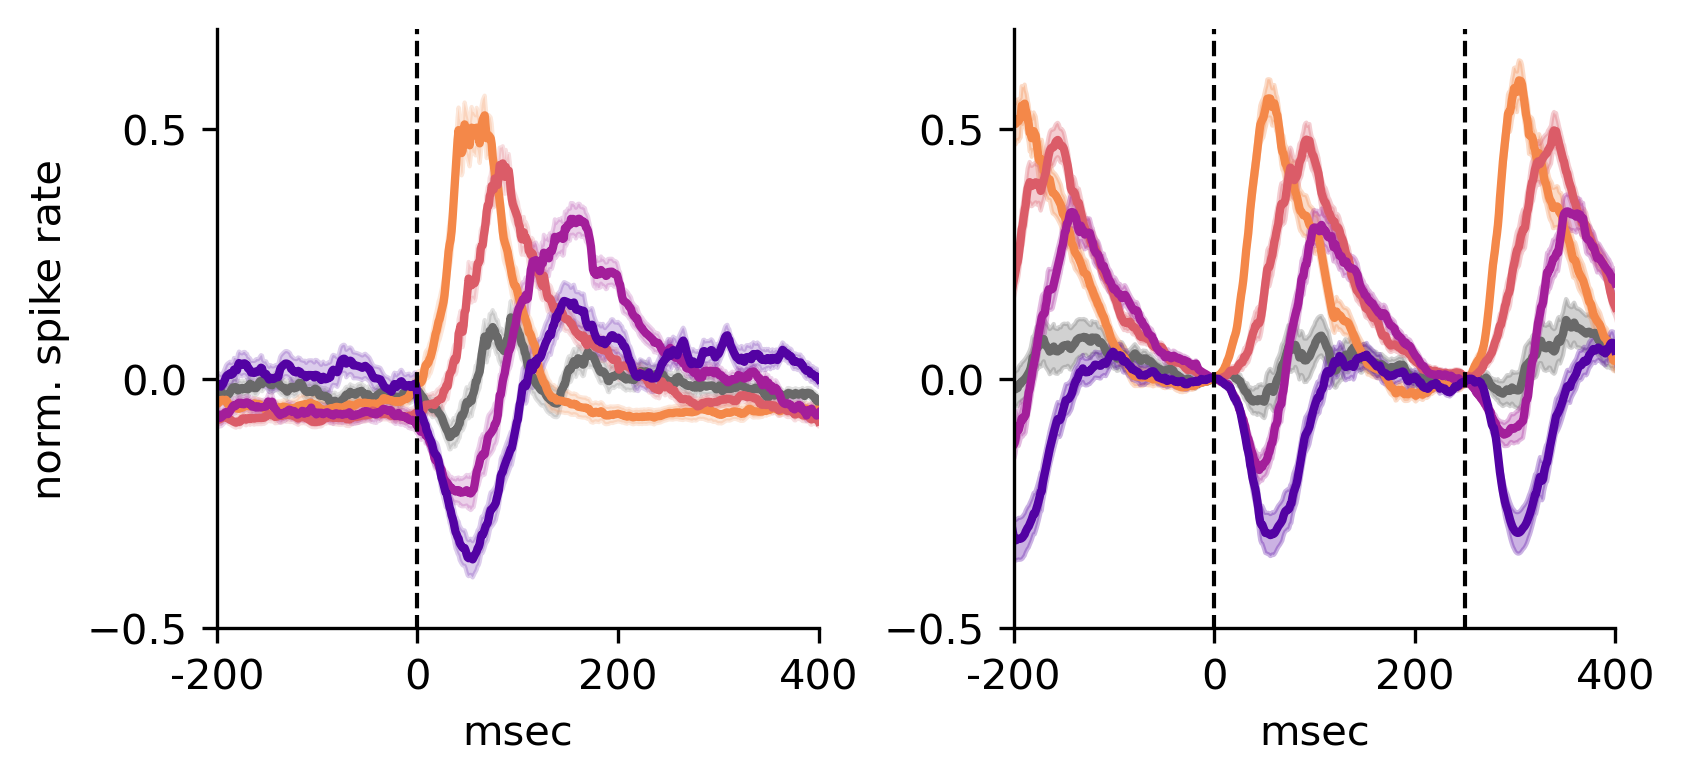

In [229]:
fig4B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig4Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig4B, wspace=0.01, hspace=0)

ax_light_clusters = fig4B.add_subplot(fig4Bspec[:,0])
ax_dark_clusters = fig4B.add_subplot(fig4Bspec[:,1])

step = 0.14
names = ['unresponsive','early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm[hffm['gazecluster']==name][hffm['Rc_responsive']]
    cluster_psths = flatten_series(data['norm_Rc_psth'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.5,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = hffm[hffm['gazecluster']==name][hffm['Sn_responsive']]
    cluster_psths = flatten_series(data['norm_Sn_psth'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.5,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_dark_clusters.vlines(.25,-1,1,color='k',linestyle='dashed',linewidth=1)

fig4B.savefig(os.path.join(figpath, '4_clustering_withUnresp.pdf'))

## head-fixed temporal sequence

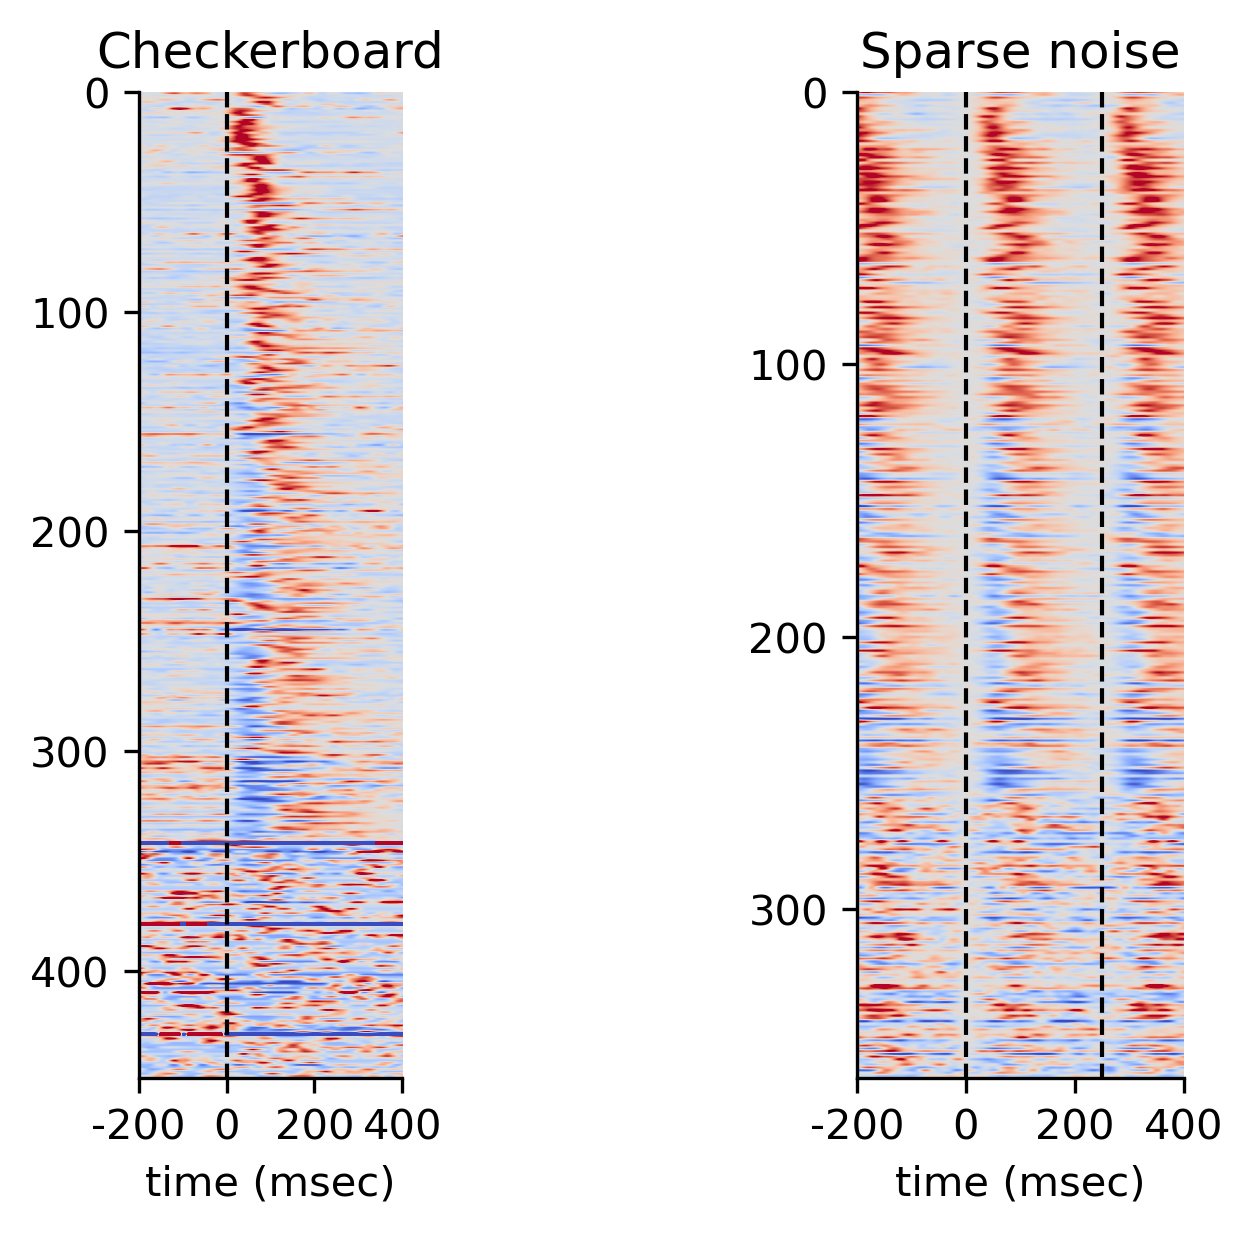

In [379]:
fig3C = plt.figure(constrained_layout=True, figsize=(5,4), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3C, wspace=0, hspace=0.5)

# ax_tseq_gaze1 = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_rc = fig3C.add_subplot(fig3Cspec[:,0])
# ax_tseq_gaze2 = fig3C.add_subplot(fig3Cspec[:,2])
ax_tseq_sn = fig3C.add_subplot(fig3Cspec[:,1])

tseq_aspect = 5

# plot_tempseq(ax_tseq_gaze1, tseq_pref_rc1)
# ax_tseq_gaze1.set_aspect(tseq_aspect)
# ax_tseq_gaze1.set_ylabel('cells')
# ax_tseq_gaze1.set_title('Gaze-shifting')
# ax_tseq_gaze1.set_yticks(np.arange(0,np.size(tseq_pref_rc1,0),100))

sz = np.size(drop_nan_along(tseq_rc1),0)
plot_tempseq(ax_tseq_rc, drop_nan_along(tseq_rc1))
ax_tseq_rc.set_aspect(tseq_aspect)
ax_tseq_rc.set_title('Checkerboard')
# ax_tseq_rc.vlines(1250, 0, sz, linestyle='dashed', linewidth=1, color='k')
ax_tseq_rc.set_yticks(np.arange(0,sz,100))
# ax_tseq_rc.hlines(len(hffm[hffm['Rc_responsive']][hffm['gazeshift_responsive']].index.values),
#                800,1400, color='k', linewidth=1, linestyle='dashed')

# plot_tempseq(ax_tseq_gaze2, tseq_pref_sn1)
# ax_tseq_gaze2.set_aspect(tseq_aspect)
# ax_tseq_gaze2.set_ylabel('cells')
# ax_tseq_gaze2.set_title('Gaze-shifting')
# ax_tseq_gaze2.set_yticks(np.arange(0,np.size(tseq_pref_sn1,0),100))

sz = np.size(drop_nan_along(tseq_sn1),0)
plot_tempseq(ax_tseq_sn, drop_nan_along(tseq_sn1))
ax_tseq_sn.set_aspect(tseq_aspect)
ax_tseq_sn.set_title('Sparse noise')
ax_tseq_sn.set_yticks(np.arange(0,sz,100))
ax_tseq_sn.vlines(1250, 0, sz, linestyle='dashed', linewidth=1, color='k')
# ax_tseq_sn.hlines(len(hffm[hffm['Sn_responsive']][hffm['gazeshift_responsive']].index.values),
#                800,1400, color='k', linewidth=1, linestyle='dashed')

# fig3C.savefig(os.path.join(figpath, '4_temp_seq.pdf'))

In [242]:
tseq_legend_col = sorted_df['gazecluster'][sorted_df['Sn_responsive']].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
# for i, n in enumerate(tseq_legend_col):
#     tseq_legend[i,:,:] = ucmap
u = np.zeros([np.size(tseq_unresp_sn,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend_sn = np.vstack([tseq_legend, u])

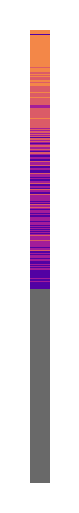

In [243]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend_sn, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '4_temp_seq_legend_Sn.pdf'))

In [240]:
tseq_legend_col = sorted_df['gazecluster'][sorted_df['Rc_responsive']].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = mpl.colors.to_rgba(cat_cmap[n])
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
# for i, n in enumerate(tseq_legend_col):
#     tseq_legend[i,:,:] = ucmap
u = np.zeros([np.size(tseq_unresp_rc,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]
tseq_legend_rc = np.vstack([tseq_legend, u])

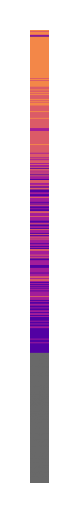

In [241]:
fig, ax = plt.subplots(1,1,figsize=(0.5,2), dpi=300)
ax.imshow(tseq_legend_rc, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
ax.axes.spines.bottom.set_visible(False)
ax.axes.spines.right.set_visible(False)
ax.axes.spines.left.set_visible(False)
ax.axes.spines.top.set_visible(False)
fig.savefig(os.path.join(figpath, '4_temp_seq_legend_Rc.pdf'))

In [244]:
from scipy import stats
def running_median(panel, x, y, n_bins=7):
    bins = np.linspace(np.min(x), np.max(x), n_bins)
    bin_means, bin_edges, bin_number = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.median, bins=bins)
    bin_std, _, _ = stats.binned_statistic(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], statistic=np.nanstd, bins=bins)
    hist, _ = np.histogram(x[~np.isnan(x) & ~np.isnan(y)], bins=bins)
    tuning_err = bin_std / np.sqrt(hist)
    panel.plot(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means, '-', color='k')
    panel.fill_between(bin_edges[:-1] + (np.median(np.diff(bins))/2), bin_means-tuning_err, bin_means+tuning_err, color='k', alpha=0.2)

In [245]:
hffm['gaze_rc_maxcc'] = np.nan
hffm['gaze_sn_maxcc'] = np.nan
for ind, row in hffm[['norm_Rc_psth','norm_Sn_psth','pref_gazeshift_psth','Rc_responsive','Sn_responsive']][hffm['use']==True].iterrows():
    if row['Rc_responsive']:
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Rc_psth'].astype(float)[1000:1250])
        hffm.at[ind, 'gaze_rc_maxcc'] = r[0,1]
    if row['Sn_responsive']:
        r = np.corrcoef(row['pref_gazeshift_psth'].astype(float)[1000:1250], row['norm_Sn_psth'].astype(float)[1000:1250])
        hffm.at[ind, 'gaze_sn_maxcc'] = r[0,1]

In [246]:
rc_vals = hffm['gaze_rc_maxcc'][hffm['gazecluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)
sn_vals = hffm['gaze_sn_maxcc'][hffm['gazecluster']!='unresponsive'].copy().dropna().reset_index(drop=True).to_numpy().astype(float)


## Corcoef and latency times

In [248]:
from scipy.stats import linregress

In [305]:
def plot_linregress(ax, x_in, y_in):
    x = x_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
    y = y_in[(~np.isnan(x_in)) * (~np.isnan(y_in))]
    res = linregress(x, y)
    minval = np.min(x); maxval = np.max(x)
    border = (maxval - minval) * 0.1
    plotx = np.linspace(minval+border, maxval-border, 2)
    ax.plot(plotx, (res.slope*plotx) + res.intercept, color='k', linewidth=2)
    return res

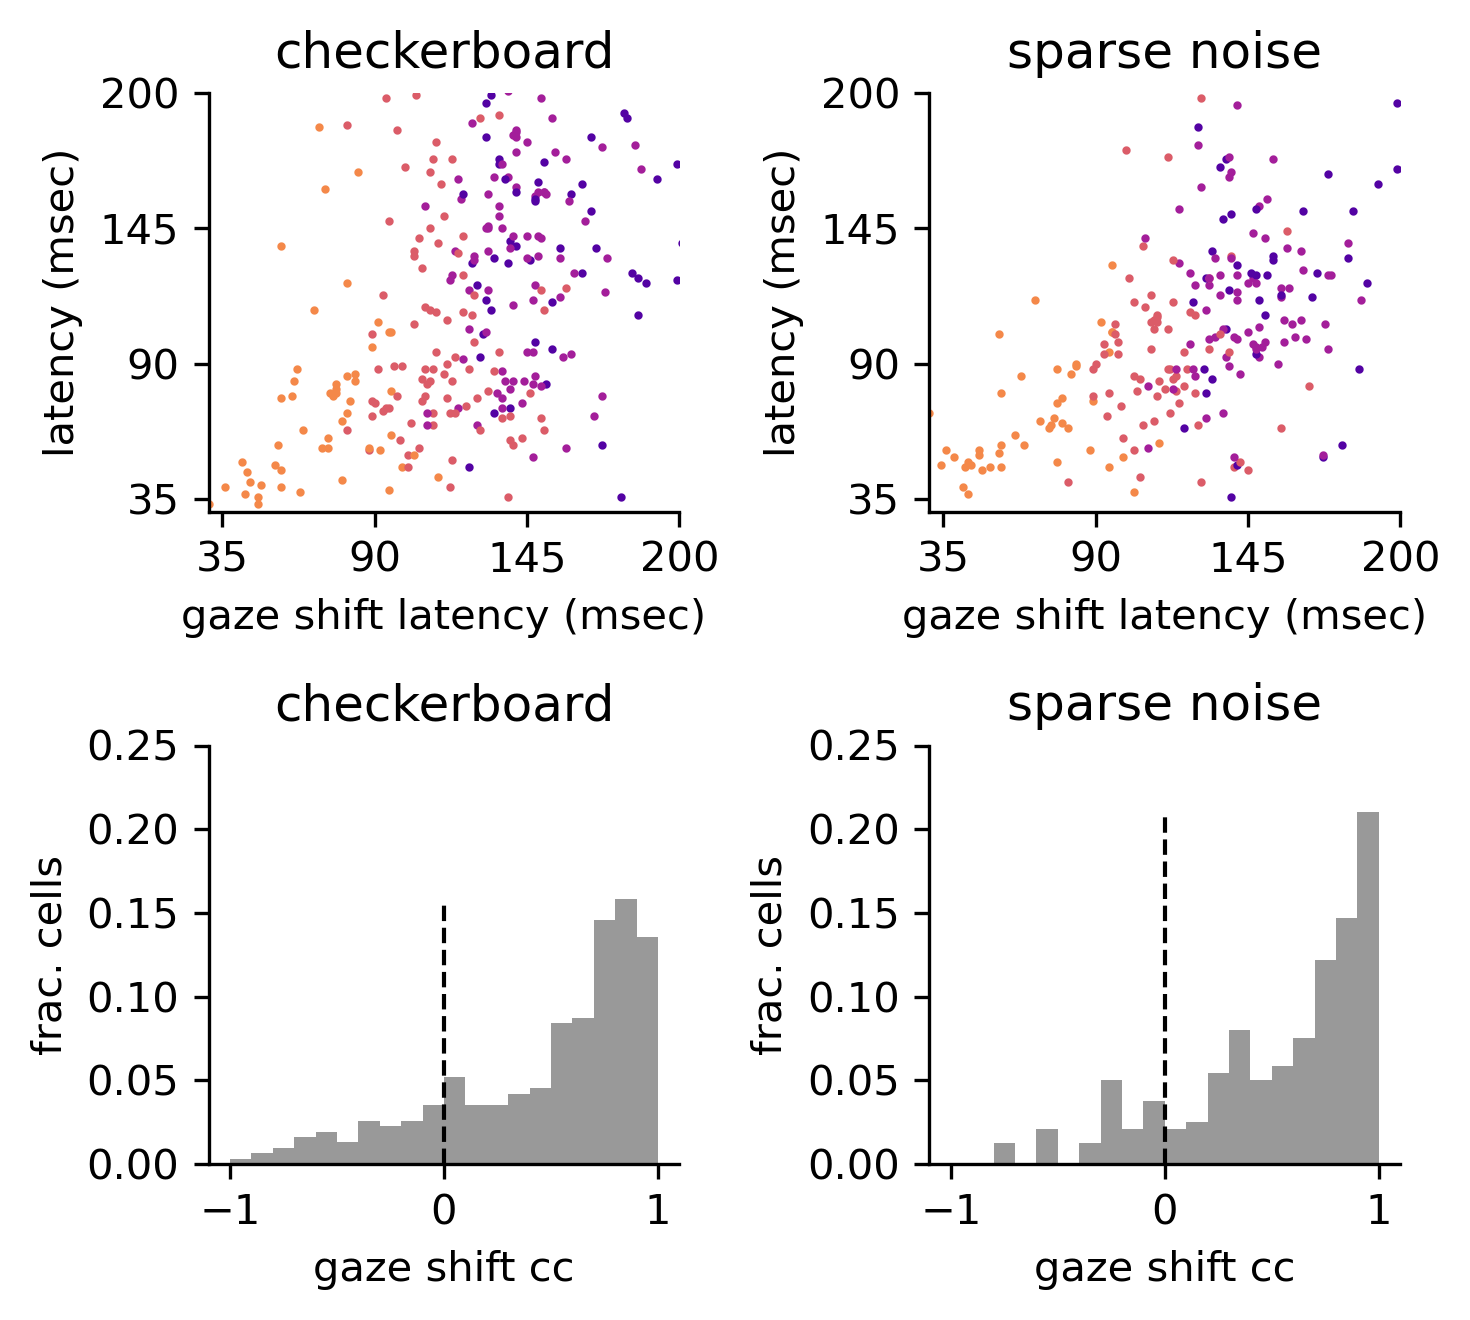

In [275]:
fig, axs = plt.subplots(2,2,figsize=(5,4.5), dpi=300)
for ind, row in hffm[['gazecluster','FmLt_gazeshift_peakT','rc_peakT','sn_peakT','Rc_responsive','Sn_responsive']][hffm['gazecluster']!='unresponsive'].iterrows():
    if row['Rc_responsive']==True:
        axs[0,0].plot(row['FmLt_gazeshift_peakT'], row['rc_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)
    if row['Sn_responsive']==True:
        axs[0,1].plot(row['FmLt_gazeshift_peakT'], row['sn_peakT'], '.', color=cat_cmap[row['gazecluster']], markersize=2)
axs[0,0].set_xlim([.030,.200]); axs[0,0].set_ylim([.030,.200])
axs[0,1].set_xlim([.030,.200]); axs[0,1].set_ylim([.030,.200])
axs[0,0].set_xticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,0].set_yticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,1].set_xticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,1].set_yticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))
axs[0,0].set_ylabel('latency (msec)'); axs[0,0].set_xlabel('gaze shift latency (msec)')
axs[0,1].set_ylabel('latency (msec)'); axs[0,1].set_xlabel('gaze shift latency (msec)')
axs[0,0].set_title('checkerboard')
axs[0,1].set_title('sparse noise')


# use_Rc = hffm[hffm['FmLt_gazeshift_peakT']>.035][hffm['FmLt_gazeshift_peakT']<.2][hffm['rc_peakT']>.035][hffm['rc_peakT']<.2][hffm['gazecluster']!='unresponsive'][hffm['Rc_responsive']==True].copy()
# use_Sn = hffm[hffm['FmLt_gazeshift_peakT']>.035][hffm['FmLt_gazeshift_peakT']<.2][hffm['rc_peakT']>.035][hffm['rc_peakT']<.2][hffm['gazecluster']!='unresponsive'][hffm['Sn_responsive']==True].copy()

# rc_R = plot_linregress(axs[0,0], use_Rc['FmLt_gazeshift_peakT'], use_Rc['rc_peakT'])
# sn_R = plot_linregress(axs[0,1], use_Sn['FmLt_gazeshift_peakT'], use_Sn['sn_peakT'])

# print('Rc:{}; Sn:{}'.format(rc_R.rvalue, sn_R.rvalue))

axs[0,0].plot([.03,.03], [.25,.25])#, 'k--', linewidth=1)#, linestyle='dashed')
axs[0,1].plot([.03,.03], [.25,.25], 'k--', linewidth=1)#, linestyle='dashed')

Rc_weights = np.ones_like(rc_vals) / float(len(rc_vals))
n,_,_ = axs[1,0].hist(rc_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Rc_weights)
axs[1,0].set_xlabel('gaze shift cc'); axs[1,0].set_ylabel('frac. cells')
axs[1,0].plot([0,0], [0, np.max(n)], color='k', linewidth=1, linestyle='dashed')
axs[1,0].set_ylim([0,.25])

Sn_weights = np.ones_like(sn_vals) / float(len(sn_vals))
n,_,_ = axs[1,1].hist(sn_vals, color='grey', bins=np.linspace(-1,1,21), alpha=0.8, weights=Sn_weights)
axs[1,1].set_xlabel('gaze shift cc'); axs[1,1].set_ylabel('frac. cells')
axs[1,1].plot([0,0], [0, np.max(n)], color='k', linewidth=1, linestyle='dashed')
axs[1,1].set_ylim([0,.25])

axs[1,0].set_title('checkerboard')
axs[1,1].set_title('sparse noise')

plt.tight_layout()
fig.savefig(os.path.join(figpath, '4_cc_unity.pdf'))

# Fig 5

## responsive to gratings

In [276]:
for ind, row in hffm.iterrows():
    raw_psth = row['pref_gazeshift_psth_raw']
    norm_psth = row['pref_gazeshift_psth']
    
    peakT, peak_val = calc_latency(norm_psth)
    
    hffm.at[ind, 'FmLt_gazeshift_baseline'] = raw_psth[0:800].astype(object)
    hffm.at[ind, 'FmLt_gazeshift_med_baseline'] = np.median(raw_psth[0:800])
    hffm.at[ind, 'FmLt_gazeshift_peak_val'] = peak_val
    hffm.at[ind, 'FmLt_gazeshift_peakT'] = peakT

In [277]:
def normalize_gt_psth(psth):
    baseline_val = np.nanmedian(psth[:5])
    norm_psth = (psth - baseline_val) / np.nanmax(np.abs(psth[5:14].astype(float)))
    return norm_psth

def gt_modind(psth):
    psth = psth.astype(float)
    use = psth - np.mean(psth[1:5].copy())
    mod = np.max(use[5:8])
    return mod

In [278]:
for ind, row in hffm.iterrows():
    hffm.at[ind, 'norm_gratings_psth'] = normalize_gt_psth(row['Gt_grating_psth'].astype(float)).astype(object)
    
for ind, row in hffm.iterrows():
    sec = row['Gt_eyeT'][-1].astype(float) - row['Gt_eyeT'][0].astype(float)
    sp = len(row['Gt_spikeT'])
    hffm.at[ind, 'Gt_fr'] = sp/sec
    
    hffm.at[ind, 'raw_mod_for_Gt'] = gt_modind(row['Gt_grating_psth'].astype(float))
    
    hffm.at[ind, 'norm_mod_for_Gt'] = gt_modind(row['norm_gratings_psth'].astype(float))
    
    # psth = row['Gt_grating_psth']
    # baseline = np.median(psth[1:5].copy())
    # peak = np.median(psth[5:14].copy())
    # data.at[ind, 'raw_mod_for_Gt'] = peak - baseline
    
hffm['Gt_responsive'] = False
for ind, row in hffm.iterrows():
    if (row['raw_mod_for_Gt']>1) and (row['norm_mod_for_Gt']>0.1):
        hffm.at[ind, 'Gt_responsive'] = True

print(hffm['Gt_responsive'].sum())
print(hffm['Gt_responsive'].sum()/len(hffm.index.values))

418
0.5837988826815642


## clusters

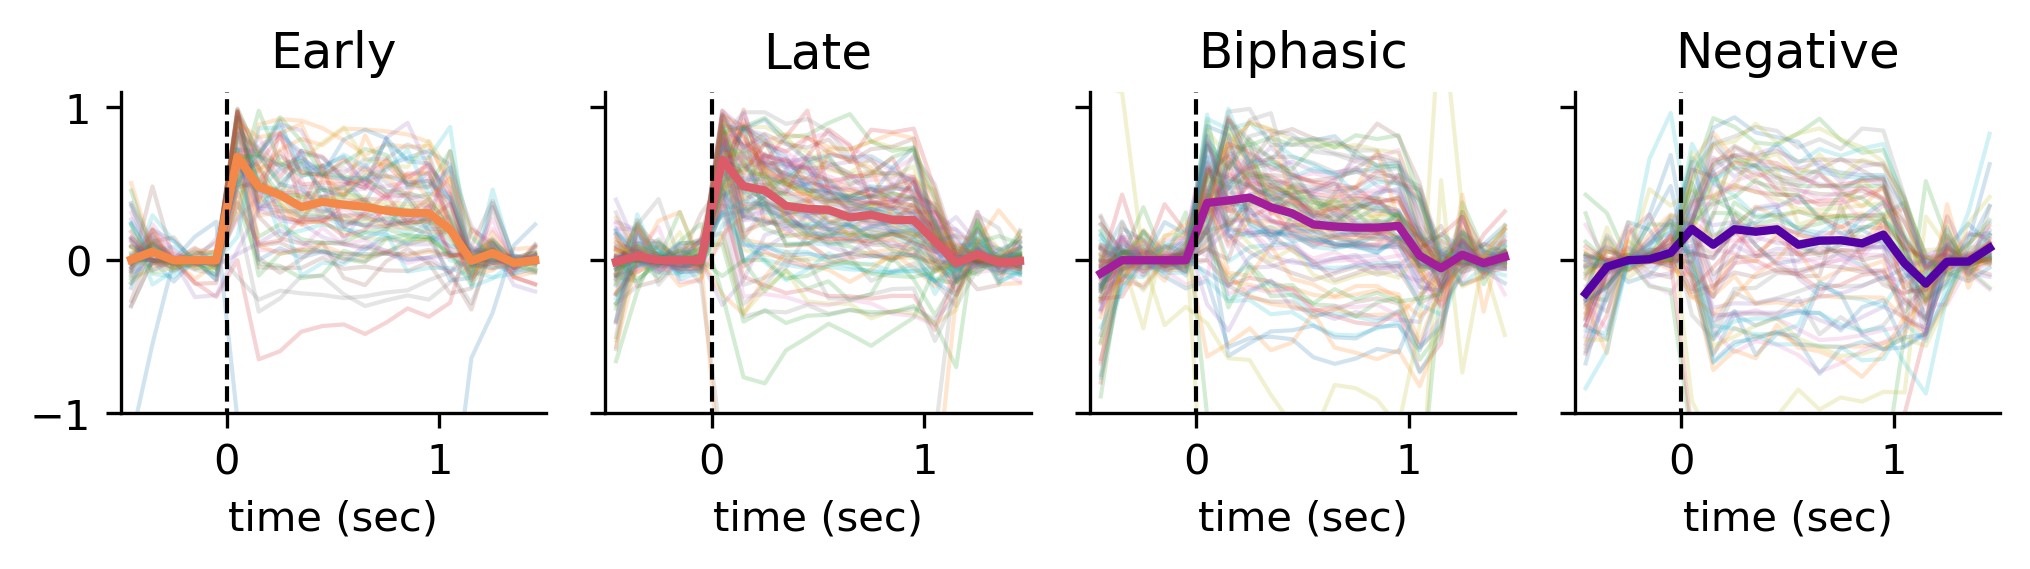

In [279]:
fig, [ax0, ax1, ax2, ax3] = plt.subplots(1,4, dpi=300, figsize=(7,2))

lower = -0.5; upper = 1.5; grat_dt = 0.1
gratbins = np.arange(lower,upper+grat_dt,grat_dt)
grat_psth_x = gratbins[0:-1]+ grat_dt/2

panels = [ax0, ax1, ax2, ax3]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm['norm_gratings_psth'][hffm['gazecluster']==movtype][hffm['Gt_responsive']==True]
    for i, psth in enumerate(thisclust):
        panel.plot(grat_psth_x, psth, '-', linewidth=1, alpha=0.2)
    clustmean = np.nanmedian(flatten_series(thisclust),0)
    panel.plot(grat_psth_x, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.vlines(0,-1.5,1.5,color='k',linestyle='dashed',linewidth=1)
    panel.set_ylim([-1,1.1])
    panel.set_xlim([-0.5,1.5])
    panel.set_title(movtype.capitalize())
    if count!=0:
        panel.set_yticklabels([])
    panel.set_xlabel('time (sec)')
plt.tight_layout()
fig.savefig(os.path.join(figpath, '5_clusters.pdf'))

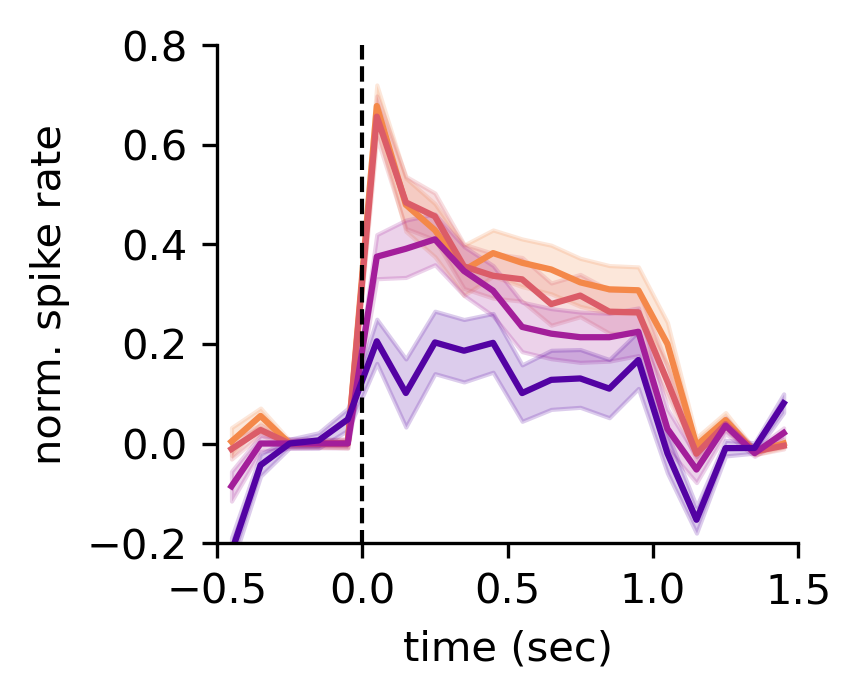

In [280]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.2), dpi=300)

names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm['norm_gratings_psth'][hffm['gazecluster']==name][hffm['Gt_responsive']==True])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax.plot(grat_psth_x, clustmean, '-', linewidth=1.5, color=cat_cmap[name])
    ax.fill_between(grat_psth_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax.set_ylabel('norm. spike rate'); ax.set_xlabel('time (sec)')
ax.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax.set_ylim([-0.2,0.8])
ax.set_xlim([-0.5,1.5])
fig.savefig(os.path.join(figpath, '5_summary.pdf'))

## sf/tf props

In [281]:
from scipy.stats import linregress

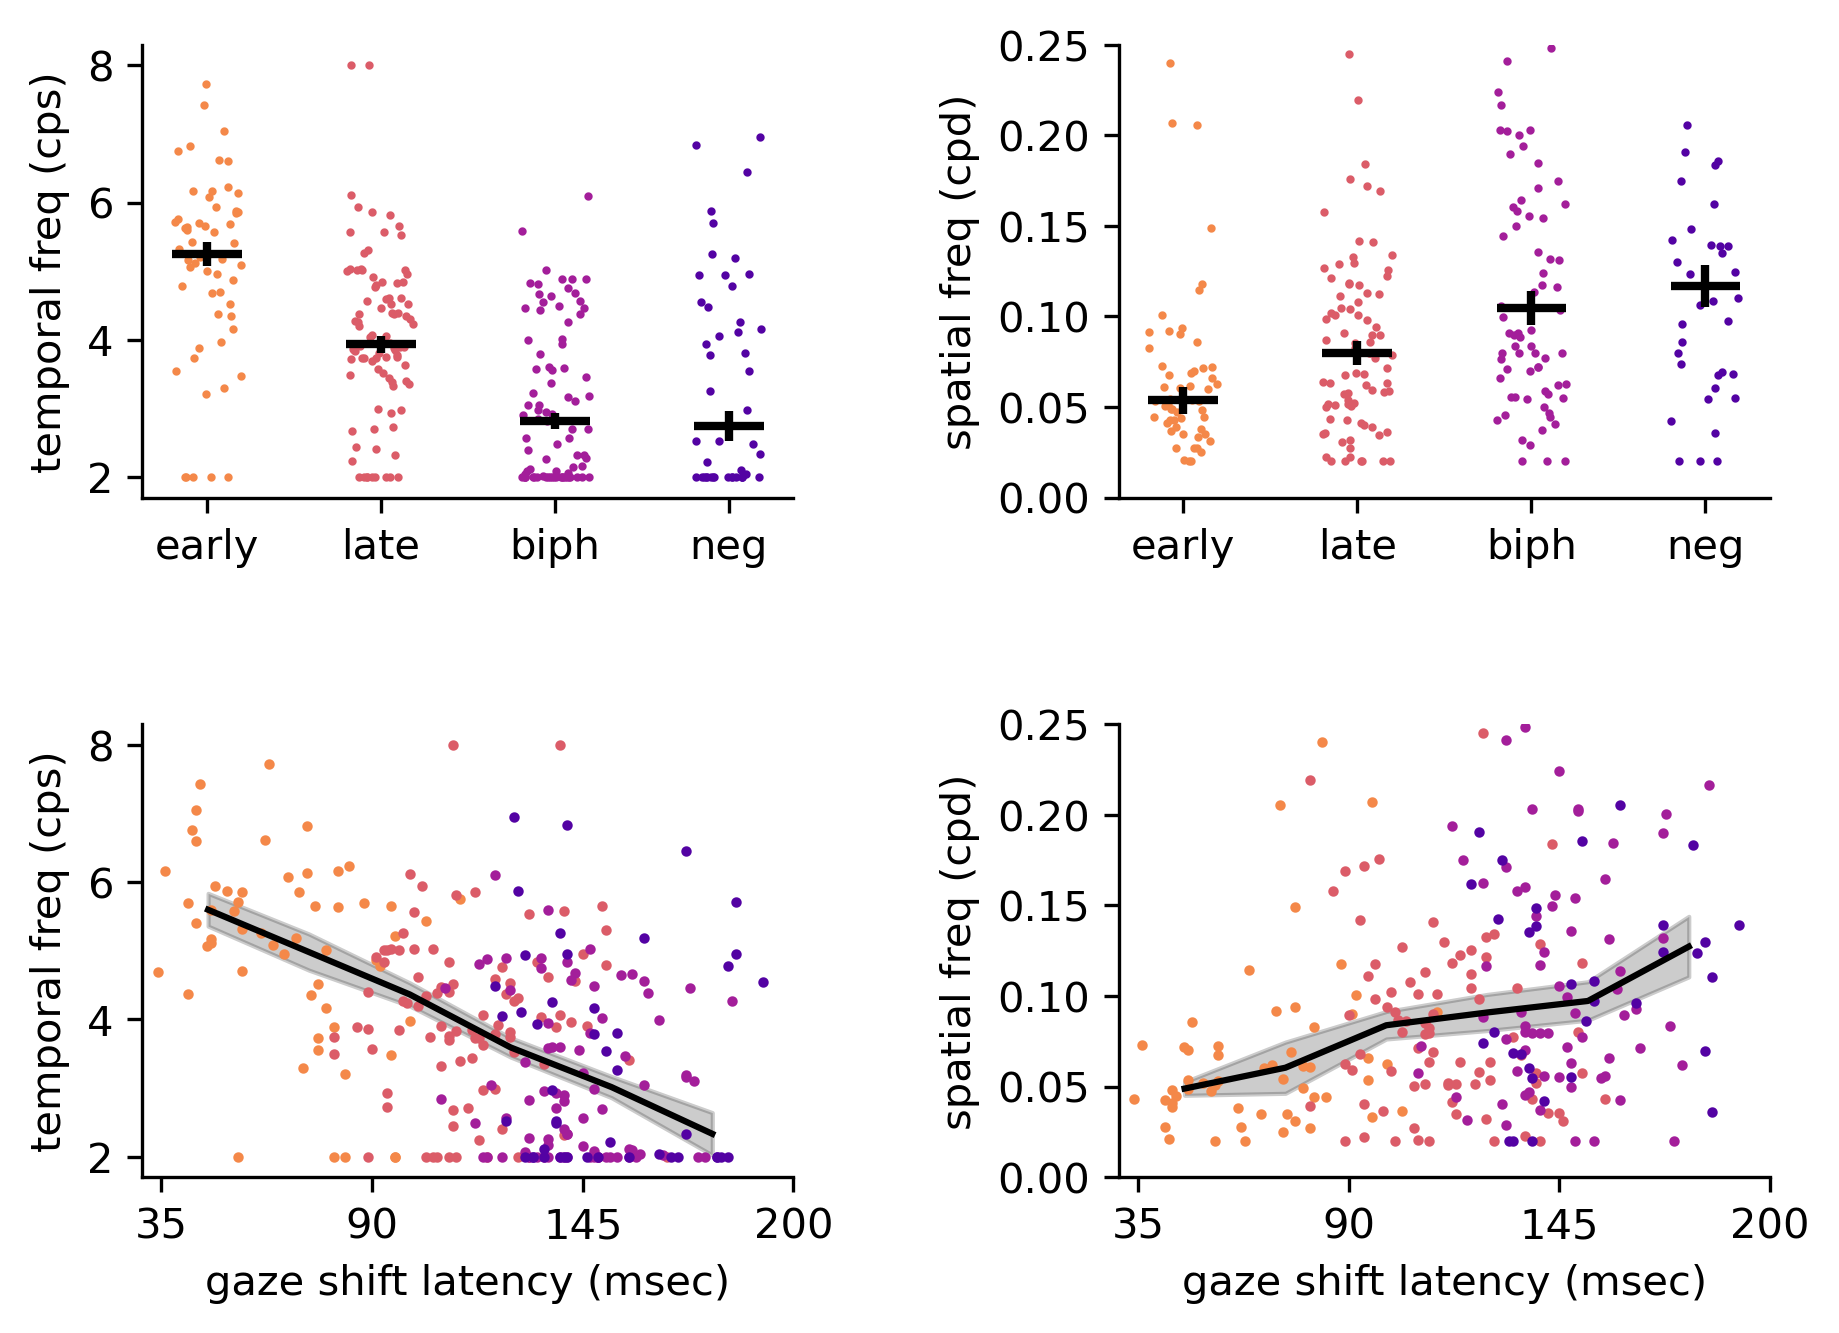

In [377]:
fig5 = plt.figure(constrained_layout=False, figsize=(7,8), dpi=300)
fig5spec = gridspec.GridSpec(nrows=3, ncols=2, figure=fig5, wspace=.5, hspace=.5)

fig5Cspec = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec=fig5spec[1:3,0:2], wspace=.5, hspace=.5)
ax_tf_cat = fig5.add_subplot(fig5Cspec[0,0])
ax_tf_scatter = fig5.add_subplot(fig5Cspec[1,0])
ax_sf_cat = fig5.add_subplot(fig5Cspec[0,1])
ax_sf_scatter = fig5.add_subplot(fig5Cspec[1,1])

use_data = hffm[hffm['gazecluster']!='unresponsive'][hffm['FmLt_gazeshift_peakT']>0.033][hffm['FmLt_gazeshift_peakT']<.2][hffm['Gt_responsive']==True].copy()

plot_cprop_scatter(ax_tf_cat, use_data, 'tf_pref_cps', use_median=True)
ax_tf_cat.set_ylabel('temporal freq (cps)')
ax_tf_cat.set_xticks(range(4), labels=['early','late','biph','neg'])

plot_cprop_scatter(ax_sf_cat, use_data, 'sf_pref_cpd', use_median=True)
ax_sf_cat.set_ylabel('spatial freq (cpd)')
ax_sf_cat.set_xticks(range(4), labels=['early','late','biph','neg'])
ax_sf_cat.set_ylim([0,0.25])

###
names = ['early','late','biphasic','negative']
for i, name in enumerate(names):
    # cluster = hffm[hffm['movcluster']==name][hffm['responsive_to_gratings']==True][hffm['Fm_fr']>2][hffm['Gt_fr']>2]
    cluster = use_data[use_data['gazecluster']==name].copy()
    ax_tf_scatter.plot(cluster['FmLt_gazeshift_peakT'], cluster['tf_pref_cps'], '.', color=cat_cmap[name], markersize=3)
    ax_sf_scatter.plot(cluster['FmLt_gazeshift_peakT'], cluster['sf_pref_cpd'], '.', color=cat_cmap[name], markersize=3)
    #[cluster['fr']>2]
# running_median(ax_tf_scatter, hffm['FmLt_gazeshift_peakT'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True], hffm['tf_pref_cps'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True])
# running_median(ax_sf_scatter, hffm['FmLt_gazeshift_peakT'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True], hffm['sf_pref_cpd'][hffm['movcluster']!='unresponsive'][hffm['responsive_to_gratings']==True])

running_median(ax_tf_scatter, use_data['FmLt_gazeshift_peakT'], use_data['tf_pref_cps'], n_bins=7)
running_median(ax_sf_scatter, use_data['FmLt_gazeshift_peakT'], use_data['sf_pref_cpd'], n_bins=7)

# ax_tf_scatter.set_yscale('log')
# ax_sf_scatter.set_yscale('log')

# tf_R = plot_linregress(ax_tf_scatter, use_data['FmLt_gazeshift_peakT'], np.log(use_data['tf_pref_cps']))
# sf_R = plot_linregress(ax_sf_scatter, use_data['FmLt_gazeshift_peakT'], np.log(use_data['sf_pref_cpd']))

ax_tf_scatter.set_xlim([.030,.200])
ax_sf_scatter.set_xlim([.030,.200])
ax_tf_scatter.set_xticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_sf_scatter.set_xticks(np.linspace(.035, 0.200, 4), labels=np.linspace(35, 200, 4).astype(int))

# ax_tf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_tf_scatter.set_xlabel('gaze shift latency (msec)')
ax_tf_scatter.set_ylabel('temporal freq (cps)')

# ax_sf_scatter.set_xticks(np.linspace(.035, 0.2, 4), labels=np.linspace(35, 200, 4).astype(int))
ax_sf_scatter.set_xlabel('gaze shift latency (msec)')
ax_sf_scatter.set_ylabel('spatial freq (cpd)')
ax_sf_scatter.set_ylim([0,0.25])

fig5.savefig(os.path.join(figpath, '5_props.pdf'))

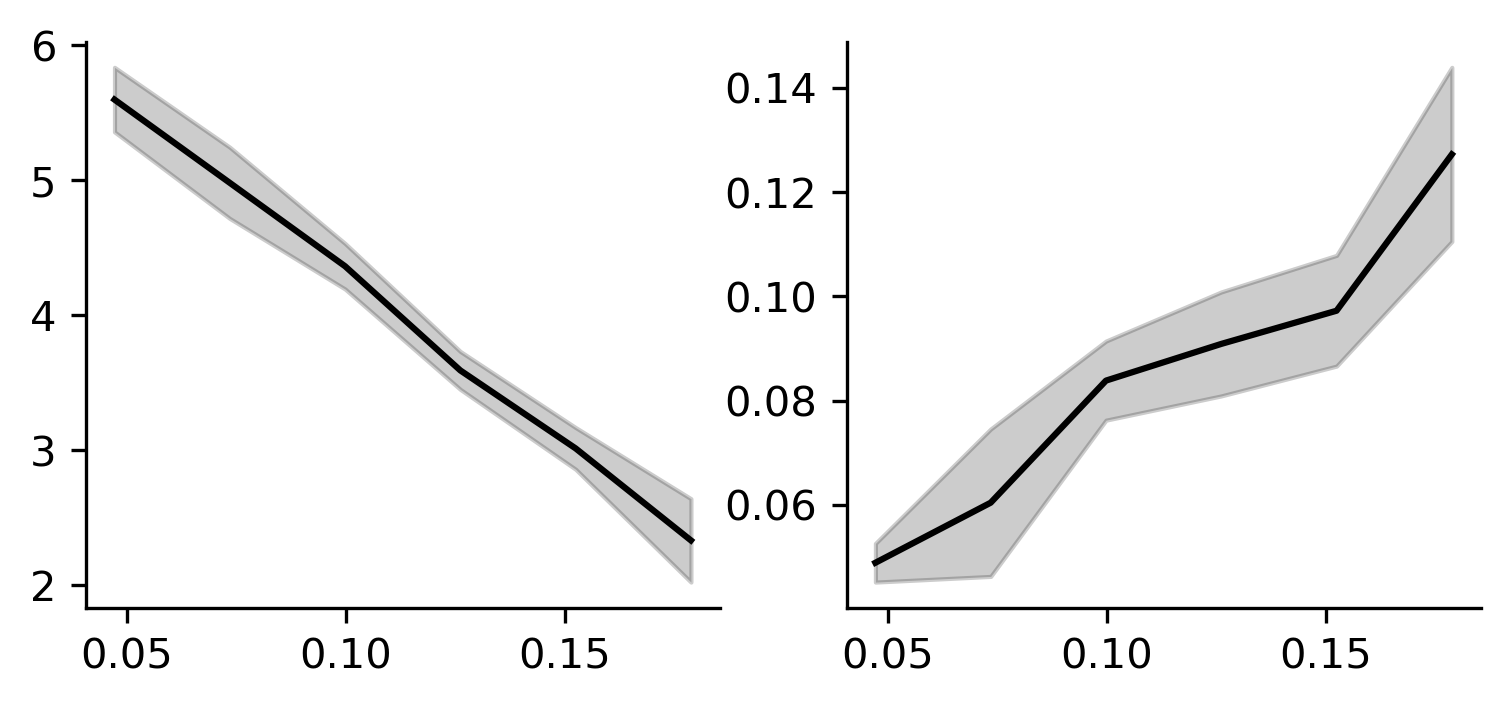

In [367]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(6,2.5), dpi=300)
running_median(ax0, use_data['FmLt_gazeshift_peakT'], use_data['tf_pref_cps'], n_bins=7)
running_median(ax1, use_data['FmLt_gazeshift_peakT'], use_data['sf_pref_cpd'], n_bins=7)

In [290]:
pd.isnull(use_data['FmLt_gazeshift_peakT']).sum()

0

In [292]:
pd.isnull(use_data['tf_pref_cps']).sum()

12

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'],
            hffm['tf_pref_cps'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'])

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['gazeshift_responsive']],
            hffm['tf_pref_cps'][hffm['Gt_responsive']][hffm['gazeshift_responsive']])
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'][hffm['gazeshift_responsive']],
            hffm['tf_pref_cps'][hffm['gazeshift_responsive']][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'], c='r')

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['gazeshift_responsive']],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['gazeshift_responsive']])
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']=='032022_J599LT_control_Rig2'][hffm['gazeshift_responsive']],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['gazeshift_responsive']][hffm['session']=='032022_J599LT_control_Rig2'], c='r')

In [ ]:
plt.scatter(hffm['FmLt_gazeshift_peakT'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'],
            hffm['sf_pref_cpd'][hffm['Gt_responsive']][hffm['session']!='032022_J599LT_control_Rig2'])

In [ ]:
hffm['session'].unique()

In [ ]:
res

# why is old clustering different?

In [ ]:
hffm['movcluster'].value_counts(normalize=True)

In [ ]:
hffm['gazecluster'].value_counts(normalize=True)

In [ ]:
before = hffm['movcluster']
after = hffm['gazecluster']

In [ ]:
transition = np.zeros([5,5])
names = ['early','late','biphasic','negative','unresponsive']
for i, n1 in enumerate(names):
    for j, n2 in enumerate(names):
        val = len(hffm[hffm['movcluster']==n1][hffm['gazecluster']==n2])
        transition[i,j] = val

In [ ]:
for i in range(5):
    transition[i,i] = np.nan

In [ ]:
plt.imshow(transition, cmap='Greys')
plt.colorbar()
# plt.xlabel('before'); plt.ylabel('after')
plt.xticks(np.arange(5), labels=['early','late','biphasic','negative','unresponsive'], rotation=90)
plt.yticks(np.arange(5), labels=['early','late','biphasic','negative','unresponsive'])

In [ ]:
data = hffm[hffm['responsive_to_gratings']==True].copy()#[hffm['Fm_fr']>2][hffm['Gt_fr']>2].copy()

fig, ax = plt.subplots(1,1,dpi=200,figsize=(3,2))

for c, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    cluster_data = data['sf_pref_cpd'][data['movcluster']==name].to_numpy()
    color_label = data['gazecluster'][data['movcluster']==name].to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
    for i in range(len(cluster_data)):
        ax.plot(x_jitter[i], cluster_data[i], '.', color=cat_cmap[color_label[i]], markersize=2)
    hline = np.nanmedian(cluster_data)
    ax.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
    err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
    ax.vlines(c, hline-err, hline+err, color='k', linewidth=2)
ax.set_xticks(range(5), ['early','late','biphasic','negative','unresponsive'], rotation=90)
ax.set_ylim([0,0.2])

In [ ]:
data = hffm[hffm['Gt_responsive']==True][hffm['use1']].copy()#.copy()#[hffm['Fm_fr']>2][hffm['Gt_fr']>2].copy()

fig, ax = plt.subplots(1,1,dpi=200,figsize=(3,2))

for c, name in enumerate(['early','late','biphasic','negative','unresponsive']):
    cluster_data = data['sf_pref_cpd'][data['gazecluster']==name].to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(cluster_data,0))
    for i in range(len(cluster_data)):
        ax.plot(x_jitter[i], cluster_data[i], '.', color=cat_cmap[name], markersize=2)
    hline = np.nanmedian(cluster_data)
    ax.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
    err = np.std(cluster_data) / np.sqrt(np.size(cluster_data))
    ax.vlines(c, hline-err, hline+err, color='k', linewidth=2)
ax.set_xticks(range(5), ['early','late','biphasic','negative','unresponsive'], rotation=90)
ax.set_ylim([0,0.2])

In [ ]:
hffm['use1'] = False
for ind, row in hffm.iterrows():
    if (row['Fm_fr']>1) and (row['mod_at_pref_peak']>0.2):
        hffm.at[ind, 'use1'] = True
print(hffm['use1'].sum())
print(hffm['use1'].sum()/len(hffm))

In [ ]:
plt.subplots(2,3,figsize=(10,8))
names = ['early','late','biphasic','negative','unresponsive']
for n, name in enumerate(names):
    plt.subplot(2,3,n+1)
    plotvals = hffm['pref_gazeshift_psth'][hffm['gazecluster']==name][hffm['use1']]
    if len(plotvals.index.values)==0:
        continue
    cluster = flatten_series(plotvals)
    for i in range(np.size(cluster,0)):
        plt.plot(psth_bins, cluster[i,:], alpha=0.5)
    plt.plot(psth_bins, np.median(cluster,0), 'k-', linewidth=3)
    plt.title('{} (N={})'.format(name, len(plotvals)))
    plt.xlim([-0.1,0.3])
    plt.ylim([-1,1])
plt.tight_layout()

# Small tests

In [ ]:
trange = np.arange(-1, 1.1, 0.025)
trange_x = 0.5*(trange[0:-1]+ trange[1:])

In [ ]:
t = -.100
np.argmin(np.abs(trange_x-t))

In [ ]:
def old_direction_pref(left, right):
    evok_left = left[39:49] # 1000:1250
    evok_right = right[39:49] # 1000:1250
    
    ind = np.argmax([np.max(np.abs(evok_left)), np.max(np.abs(evok_right))])
    pref = ['left','right'][ind]
    nonpref = ('left' if pref=='right' else 'right')
    
    return pref, nonpref
    
def old_normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.nanmean(psth[0:35].astype(float)) # 0:900
    norm_psth = (psth - baseline_val) / np.nanmax(raw_pref[39:49].astype(float))
    return norm_psth

In [ ]:
len(unresp_cells)

In [ ]:
unresp_cells = hffm[hffm['movcluster']=='unresponsive'][~pd.isnull(hffm['FmLt_leftsacc_avg_gaze_shift_dHead'])].copy()

norm_old = np.zeros([len(unresp_cells.index.values), 83])
norm_new = np.zeros([len(unresp_cells.index.values), 2001])

for i, ind in enumerate(unresp_cells.index.values):
    row = unresp_cells.loc[ind].copy()
    l = row['FmLt_leftsacc_avg_gaze_shift_dHead']
    r = row['FmLt_rightsacc_avg_gaze_shift_dHead']
    pref_str, _ = old_direction_pref(l, r)
    if pref_str=='left':
        pref = l
    else:
        pref = r
    psth = old_normalize_psth(pref)
    norm_old[i,:] = psth
    norm_new[i,:] = row['pref_gazeshift_psth']

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2,figsize=(8,4),dpi=300)
for i in range(len(norm_old)):
    ax0.plot(trange_x, norm_old[i,:], alpha=0.5)
    
    ax1.plot(psth_bins, norm_new[i,:], alpha=0.5)
    
ax0.set_xlim([-.3,.3])
ax1.set_xlim([-.3,.3])

ax0.plot(trange_x, np.median(norm_old,0), 'k')
ax0.set_title('hist')

ax1.plot(psth_bins, np.median(norm_new,0), 'k')
ax1.set_title('kde')

ax0.set_ylim([-.65,.9])
ax1.set_ylim([-.65,.9])

In [ ]:
plt.figure(dpi=200,figsize=(4,4))
current_unresp = hffm[hffm['gazecluster']=='unresponsive'].copy()
all_unresp_current = np.zeros([len(current_unresp.index.values),2001])
for i, ind in enumerate(current_unresp.index.values):
    row = current_unresp.loc[ind].copy()
    all_unresp_current[i,:] = row['pref_gazeshift_psth']
    plt.plot(psth_bins, row['pref_gazeshift_psth'],alpha=0.5)
    
plt.plot(psth_bins, np.median(all_unresp_current,0), 'k')
plt.xlim([-.3,.3])
plt.ylim([-.65,.9])